In [1]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import os
from pathlib import Path
import idd_climate_models.constants as rfc

base_path = Path('/mnt/team/rapidresponse/pub/tropical-storms/tempestextremes/outputs/cmip6/')


raw_count_file_path = '{model}_{variant}_{scenario}_basin_counts.csv'
scaled_file_path = '{model}_{variant}_{scenario}_basin_counts_SCALED.csv'

# Scenarios to consider
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
# Dictionary to store model -> variants mapping
model_variants = {}

# List all model folders
if base_path.exists():
    for model_dir in sorted(base_path.iterdir()):
        if model_dir.is_dir():
            model_name = model_dir.name
            variants = []
            
            # List all variant folders within each model
            for variant_dir in sorted(model_dir.iterdir()):
                if variant_dir.is_dir():
                    # Check that all 4 scenario files exist for this variant
                    all_scenarios_exist = True
                    for scenario in scenarios:
                        file_name = raw_count_file_path.format(model=model_name, variant=variant_dir.name, scenario=scenario)
                        file_path = variant_dir / scenario / 'basin_counts' / file_name
                        if not file_path.exists():
                            all_scenarios_exist = False
                            break
                    if all_scenarios_exist:
                        variants.append(variant_dir.name)
            
            model_variants[model_name] = variants

# Display the results
for model, variants in model_variants.items():
    print(f"{model}: {variants}")

print(f"\nTotal models: {len(model_variants)}")
print(f"Total variants across all models: {sum(len(v) for v in model_variants.values())}")

CMCC-ESM2: ['r1i1p1f1']
EC-Earth3: ['r1i1p1f1']
MPI-ESM1-2-HR: ['r1i1p1f1']
MRI-ESM2-0: ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1']

Total models: 4
Total variants across all models: 8


In [2]:
# Create a single combined dataframe with all models, variants, scenarios
# Columns: model, variant, scenario, year, basin, unscaled_storms, scaled_global, scaled_basin
# NOTE: keep_default_na=False prevents pandas from reading 'NA' (North Atlantic) as NaN

all_data = []

for model, variants in model_variants.items():
    for variant in variants:
        # First, load the historical unscaled file to compute multipliers
        hist_path = base_path / model / variant / 'historical' / 'basin_counts' / raw_count_file_path.format(
            model=model, variant=variant, scenario='historical'
        )
        
        if not hist_path.exists():
            print(f"WARNING: Historical file not found: {hist_path}")
            raise ValueError(f"Somehow the historical file is missing for {model} {variant}")
        
        hist_df = pd.read_csv(hist_path, keep_default_na=False)
        
        # Calculate global multiplier from GL basin
        gl_hist = hist_df[hist_df['basin'] == 'GL']
        gl_storm_total = gl_hist['storm_count'].sum()
        gl_ibtracs_total = gl_hist['ibtracs_count'].sum()
        global_multiplier = gl_ibtracs_total / gl_storm_total if gl_storm_total > 0 else 1.0
        
        # Calculate basin-specific multipliers
        basin_multipliers = {}
        for basin in hist_df['basin'].unique():
            basin_hist = hist_df[hist_df['basin'] == basin]
            basin_storm_total = basin_hist['storm_count'].sum()
            basin_ibtracs_total = basin_hist['ibtracs_count'].sum()
            basin_multipliers[basin] = basin_ibtracs_total / basin_storm_total if basin_storm_total > 0 else 1.0
        
        print(f"{model} {variant}: global_mult={global_multiplier:.3f}, basin_mults={basin_multipliers}")
        
        # Now process all scenarios (including historical)
        for scenario in scenarios:
            scenario_path = base_path / model / variant / scenario / 'basin_counts' / raw_count_file_path.format(
                model=model, variant=variant, scenario=scenario
            )
            
            if not scenario_path.exists():
                raise ValueError(f"Somehow the {scenario} file is missing for {model} {variant}")

            
            scenario_df = pd.read_csv(scenario_path, keep_default_na=False)
            
            # Apply scaling
            for _, row in scenario_df.iterrows():
                basin = row['basin']
                unscaled = row['storm_count']
                scaled_global = unscaled * global_multiplier
                scaled_basin = unscaled * basin_multipliers.get(basin, global_multiplier)
                
                all_data.append({
                    'model': model,
                    'variant': variant,
                    'scenario': scenario,
                    'year': row['year'],
                    'basin': basin,
                    'unscaled_storms': unscaled,
                    'scaled_global': scaled_global,
                    'scaled_basin': scaled_basin
                })

# Create the combined dataframe
combined_df = pd.DataFrame(all_data)
print(f"\nCombined dataframe shape: {combined_df.shape}")
print(f"Unique basins: {combined_df['basin'].unique()}")
print(combined_df.head(20))

CMCC-ESM2 r1i1p1f1: global_mult=2.577, basin_mults={'AU': np.float64(2.1742424242424243), 'EP': np.float64(4.953125), 'GL': np.float64(2.576769025367156), 'NA': np.float64(35.111111111111114), 'NI': np.float64(1.4161073825503356), 'SI': np.float64(1.6549295774647887), 'SP': np.float64(1.6989247311827957), 'WP': np.float64(2.4318181818181817)}
EC-Earth3 r1i1p1f1: global_mult=1.929, basin_mults={'AU': np.float64(1.4422110552763818), 'EP': np.float64(3.2346938775510203), 'GL': np.float64(1.9290354822588707), 'NA': np.float64(9.575757575757576), 'NI': np.float64(3.5166666666666666), 'SI': np.float64(1.1928934010152283), 'SP': np.float64(1.0128205128205128), 'WP': np.float64(2.204119850187266)}
MPI-ESM1-2-HR r1i1p1f1: global_mult=3.607, basin_mults={'AU': np.float64(2.1797752808988764), 'EP': np.float64(4.510729613733906), 'GL': np.float64(3.6067708333333335), 'NA': np.float64(23.466666666666665), 'NI': np.float64(3.0579710144927534), 'SI': np.float64(1.8928571428571428), 'SP': np.float64(4

In [3]:
# Evaluate: Is basin-specific scaling better than global scaling?
# Compare against ibtracs_count on historical period
# NOTE: keep_default_na=False prevents pandas from reading 'NA' (North Atlantic) as NaN

from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

evaluation_results = []

for model, variants in model_variants.items():
    for variant in variants:
        hist_path = base_path / model / variant / 'historical' / 'basin_counts' / raw_count_file_path.format(
            model=model, variant=variant, scenario='historical'
        )
        
        if not hist_path.exists():
            continue
        
        hist_df = pd.read_csv(hist_path, keep_default_na=False)
        
        # Get multipliers (same logic as cell 2)
        gl_hist = hist_df[hist_df['basin'] == 'GL']
        gl_storm_total = gl_hist['storm_count'].sum()
        gl_ibtracs_total = gl_hist['ibtracs_count'].sum()
        global_multiplier = gl_ibtracs_total / gl_storm_total if gl_storm_total > 0 else 1.0
        
        basin_multipliers = {}
        for basin in hist_df['basin'].unique():
            basin_hist = hist_df[hist_df['basin'] == basin]
            basin_storm_total = basin_hist['storm_count'].sum()
            basin_ibtracs_total = basin_hist['ibtracs_count'].sum()
            basin_multipliers[basin] = basin_ibtracs_total / basin_storm_total if basin_storm_total > 0 else 1.0
        
        # Apply scaling and compare to ibtracs_count
        for basin in hist_df['basin'].unique():
            basin_data = hist_df[hist_df['basin'] == basin].copy()
            
            if len(basin_data) == 0 or basin_data['ibtracs_count'].sum() == 0:
                continue
            
            observed = basin_data['ibtracs_count'].values
            unscaled = basin_data['storm_count'].values
            scaled_global = unscaled * global_multiplier
            scaled_basin = unscaled * basin_multipliers[basin]
            
            # Calculate error metrics
            mae_unscaled = mean_absolute_error(observed, unscaled)
            mae_global = mean_absolute_error(observed, scaled_global)
            mae_basin = mean_absolute_error(observed, scaled_basin)
            
            rmse_unscaled = np.sqrt(mean_squared_error(observed, unscaled))
            rmse_global = np.sqrt(mean_squared_error(observed, scaled_global))
            rmse_basin = np.sqrt(mean_squared_error(observed, scaled_basin))
            
            # Correlation
            corr_unscaled = np.corrcoef(observed, unscaled)[0, 1] if np.std(observed) > 0 and np.std(unscaled) > 0 else np.nan
            corr_global = np.corrcoef(observed, scaled_global)[0, 1] if np.std(observed) > 0 and np.std(scaled_global) > 0 else np.nan
            corr_basin = np.corrcoef(observed, scaled_basin)[0, 1] if np.std(observed) > 0 and np.std(scaled_basin) > 0 else np.nan
            
            evaluation_results.append({
                'model': model,
                'variant': variant,
                'basin': basin,
                'n_years': len(basin_data),
                'global_multiplier': global_multiplier,
                'basin_multiplier': basin_multipliers[basin],
                'mae_unscaled': mae_unscaled,
                'mae_global': mae_global,
                'mae_basin': mae_basin,
                'rmse_unscaled': rmse_unscaled,
                'rmse_global': rmse_global,
                'rmse_basin': rmse_basin,
                'corr_unscaled': corr_unscaled,
                'corr_global': corr_global,
                'corr_basin': corr_basin,
                'basin_better_mae': mae_basin < mae_global,
                'basin_better_rmse': rmse_basin < rmse_global,
            })

eval_df = pd.DataFrame(evaluation_results)

# Summary statistics
print("=" * 80)
print("OVERALL: Is basin-specific scaling better?")
print("=" * 80)
print(f"Basin-specific has lower MAE:  {eval_df['basin_better_mae'].sum()} / {len(eval_df)} ({100*eval_df['basin_better_mae'].mean():.1f}%)")
print(f"Basin-specific has lower RMSE: {eval_df['basin_better_rmse'].sum()} / {len(eval_df)} ({100*eval_df['basin_better_rmse'].mean():.1f}%)")

print("\n" + "=" * 80)
print("BY MODEL: % of basins where basin-specific is better (MAE)")
print("=" * 80)
model_summary = eval_df.groupby('model')['basin_better_mae'].agg(['sum', 'count', 'mean'])
model_summary.columns = ['basin_wins', 'total', 'pct_basin_better']
model_summary['pct_basin_better'] = (model_summary['pct_basin_better'] * 100).round(1)
print(model_summary)

print("\n" + "=" * 80)
print("BY BASIN: % of model-variants where basin-specific is better (MAE)")
print("=" * 80)
basin_summary = eval_df.groupby('basin')['basin_better_mae'].agg(['sum', 'count', 'mean'])
basin_summary.columns = ['basin_wins', 'total', 'pct_basin_better']
basin_summary['pct_basin_better'] = (basin_summary['pct_basin_better'] * 100).round(1)
print(basin_summary.sort_values('pct_basin_better', ascending=False))

print("\n" + "=" * 80)
print("DETAILED: Cases where basin-specific is notably better or worse")
print("=" * 80)
eval_df['mae_improvement'] = eval_df['mae_global'] - eval_df['mae_basin']  # positive = basin is better
print("\nTop 10 cases where BASIN-SPECIFIC is better:")
print(eval_df.nlargest(10, 'mae_improvement')[['model', 'variant', 'basin', 'mae_global', 'mae_basin', 'mae_improvement']])

print("\nTop 10 cases where GLOBAL is better:")
print(eval_df.nsmallest(10, 'mae_improvement')[['model', 'variant', 'basin', 'mae_global', 'mae_basin', 'mae_improvement']])

# Store for further analysis
eval_df

OVERALL: Is basin-specific scaling better?
Basin-specific has lower MAE:  31 / 64 (48.4%)
Basin-specific has lower RMSE: 29 / 64 (45.3%)

BY MODEL: % of basins where basin-specific is better (MAE)
               basin_wins  total  pct_basin_better
model                                             
CMCC-ESM2               6      8              75.0
EC-Earth3               4      8              50.0
MPI-ESM1-2-HR           4      8              50.0
MRI-ESM2-0             17     40              42.5

BY BASIN: % of model-variants where basin-specific is better (MAE)
       basin_wins  total  pct_basin_better
basin                                     
SI              8      8             100.0
WP              7      8              87.5
SP              5      8              62.5
AU              4      8              50.0
EP              3      8              37.5
NA              2      8              25.0
NI              2      8              25.0
GL              0      8               0.0

,model,variant,basin,n_years,global_multiplier,basin_multiplier,mae_unscaled,mae_global,mae_basin,rmse_unscaled,rmse_global,rmse_basin,corr_unscaled,corr_global,corr_basin,basin_better_mae,basin_better_rmse,mae_improvement
0,CMCC-ESM2,r1i1p1f1,AU,45,2.576769,2.174242,7.155556,5.555022,4.477778,7.983316,7.294995,6.040771,0.205178,0.205178,0.205178,True,True,1.077244
1,CMCC-ESM2,r1i1p1f1,EP,45,2.576769,4.953125,16.866667,10.321881,8.859028,17.443878,11.928817,10.480282,0.167499,0.167499,0.167499,True,True,1.462853
2,CMCC-ESM2,r1i1p1f1,GL,45,2.576769,2.576769,52.488889,13.145409,13.145409,53.716540,17.306616,17.306616,-0.127952,-0.127952,-0.127952,False,False,0.000000
3,CMCC-ESM2,r1i1p1f1,NA,45,2.576769,35.111111,6.822222,6.532503,12.266667,7.538052,7.379499,18.062610,-0.088422,-0.088422,-0.088422,False,False,-5.734164
4,CMCC-ESM2,r1i1p1f1,NI,45,2.576769,1.416107,2.088889,5.020946,2.356749,2.921187,6.248390,3.115307,0.076725,0.076725,0.076725,True,True,2.664198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MRI-ESM2-0,r5i1p1f1,NA,45,1.792015,8.102564,6.155556,5.643372,6.430769,6.958608,6.498539,7.976144,0.008869,0.008869,0.008869,False,False,-0.787398
60,MRI-ESM2-0,r5i1p1f1,NI,45,1.792015,2.604938,3.377778,3.084267,3.256516,3.835507,3.555173,4.092216,-0.188666,-0.188666,-0.188666,False,False,-0.172249
61,MRI-ESM2-0,r5i1p1f1,SI,45,1.792015,1.702899,5.911111,4.920912,4.819324,6.870226,6.453445,6.295882,-0.195322,-0.195322,-0.195322,True,True,0.101588
62,MRI-ESM2-0,r5i1p1f1,SP,45,1.792015,1.795455,3.066667,3.813350,3.817172,3.759433,4.653504,4.659166,-0.314942,-0.314942,-0.314942,False,False,-0.003822


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gammaln
import ruptures as rpt
from itertools import product, combinations
import warnings
warnings.filterwarnings('ignore')
"""
CODING PHILOSOPHY: FAIL EXPLICITLY, NEVER PATCH SILENTLY
- If input is malformed, raise ValueError/TypeError immediately
- If invariants are violated, raise exceptions with clear messages
- No silent corrections, no automatic fallbacks
- Make bugs loud and obvious, not hidden
"""
class TCBinDetector:
    """
    Change point detector for tropical cyclone time series.
    Finds year bins that are CONSISTENT across all basins.
    A single constant integer per basin per bin is the goal.
    
    Key features:
    - Multi-basin analysis (same bins for all basins)
    - Enforces max_size constraint (default 30 years)
    - Computes fit quality metrics per basin and overall
    - Multiple algorithms including Bayesian Poisson
    
    Methods:
    - PELT: Pruned Exact Linear Time (Killick et al., 2012) - L2 cost
    - BayesPoisson: Bayesian Poisson changepoint with synchronized breaks
    - Window, DynP, BinSeg, BottomUp, Kernel: Various segmentation algorithms
    """
    
    def __init__(self, df, min_size=10, max_size=30):
        """
        Args:
            df: DataFrame with index=years, columns=basins, values=storm counts
            min_size: minimum bin size in years
            max_size: maximum bin size in years (hard constraint)
        """
        self.df = df
        self.years = df.index.values
        self.basins = df.columns.tolist()
        self.X = df.values  # shape: (n_years, n_basins)
        self.n = len(self.years)
        self.min_size = min_size
        self.max_size = max_size
        self.results = {}
        
    def _enforce_max_size(self, breaks):
        """Split any bins larger than max_size."""
        breaks = sorted(set(breaks))
        if len(breaks) == 0:
            breaks = [self.years[0], self.years[-1]]
        if breaks[0] != self.years[0]:
            breaks = [self.years[0]] + breaks
        if breaks[-1] != self.years[-1]:
            breaks = breaks + [self.years[-1]]
            
        # Convert to indices
        year_to_idx = {y: i for i, y in enumerate(self.years)}
        idx_breaks = [year_to_idx.get(b, 0) for b in breaks]
        idx_breaks[-1] = self.n  # Last break is end
        
        new_breaks = [idx_breaks[0]]
        for i in range(1, len(idx_breaks)):
            start, end = idx_breaks[i-1], idx_breaks[i]
            size = end - start
            if size > self.max_size:
                # Split into chunks of ~max_size
                n_splits = int(np.ceil(size / self.max_size))
                chunk_size = size // n_splits
                for j in range(1, n_splits):
                    new_breaks.append(start + j * chunk_size)
            new_breaks.append(end)
        
        # Convert back to years
        new_breaks = sorted(set(new_breaks))
        return [self.years[min(b, self.n-1)] for b in new_breaks[:-1]] + [self.years[-1]]
    
    def _compute_fit_metrics(self, breaks):
        """Compute fit quality metrics for a set of breaks across all basins."""
        year_to_idx = {y: i for i, y in enumerate(self.years)}
        idx_breaks = []
        for b in breaks[:-1]:
            if b in year_to_idx:
                idx_breaks.append(year_to_idx[b])
            else:
                raise ValueError(f"Somehow a break isn't a year in the data: {b}")
        idx_breaks.append(self.n)

        if len(idx_breaks) != len(set(idx_breaks)):
            raise ValueError(f"Somehow breaks contain duplicates: {breaks}")
        if idx_breaks != sorted(set(idx_breaks)):
            raise ValueError(f"Somehow breaks are not already in order: {breaks}")
        
        if idx_breaks[0] != 0:
            print('Failed at the first break check')
            print('First break:', breaks[0])
            print('First break idx:', idx_breaks[0])
            raise ValueError(f"Somehow the first break is not the first year")
        
        total_sse = 0
        total_mae = 0
        total_points = 0
        bin_stats = []
        basin_stats = {basin: [] for basin in self.basins}
        
        for i in range(len(idx_breaks) - 1):
            start, end = idx_breaks[i], idx_breaks[i+1]
            if start >= end:
                continue
                
            bin_info = {
                'start_year': self.years[start],
                'end_year': self.years[end-1] if end <= self.n else self.years[self.n-1],
                'size': end - start,
                'basin_means': {},
                'basin_mae': {}
            }
            
            for j, basin in enumerate(self.basins):
                segment = self.X[start:end, j]
                if len(segment) == 0:
                    continue
                mean_val = np.mean(segment)
                sse = np.sum((segment - mean_val) ** 2)
                mae = np.mean(np.abs(segment - mean_val))
                
                total_sse += sse
                total_mae += mae * len(segment)
                total_points += len(segment)
                
                bin_info['basin_means'][basin] = mean_val
                bin_info['basin_mae'][basin] = mae
                
                basin_stats[basin].append({
                    'bin_idx': i,
                    'start_year': bin_info['start_year'],
                    'end_year': bin_info['end_year'],
                    'mean': mean_val,
                    'mae': mae,
                    'sse': sse
                })
            
            bin_stats.append(bin_info)
        
        return {
            'n_bins': len(bin_stats),
            'total_sse': total_sse,
            'avg_mae': total_mae / total_points if total_points > 0 else np.inf,
            'bic': self._compute_bic(breaks),
            'poisson_bic': self._compute_poisson_bic(breaks),
            'bins': bin_stats,
            'basin_stats': basin_stats
        }
    
    def _compute_bic(self, breaks):
        """Compute BIC for model selection (Gaussian, summed across basins)."""
        n_bins = len(breaks) - 1
        if n_bins <= 0:
            return np.inf
        
        year_to_idx = {y: i for i, y in enumerate(self.years)}
        idx_breaks = [year_to_idx.get(b, 0) for b in breaks]
        if idx_breaks[-1] != self.n:
            idx_breaks[-1] = self.n
        
        total_ll = 0
        for j in range(len(self.basins)):
            for i in range(len(idx_breaks) - 1):
                start, end = idx_breaks[i], idx_breaks[i+1]
                segment = self.X[start:end, j]
                if len(segment) == 0:
                    continue
                var_val = np.var(segment) + 1e-10
                ll = -0.5 * len(segment) * (np.log(2 * np.pi * var_val) + 1)
                total_ll += ll
        
        # k = n_bins * n_basins * 2 (mean + variance per bin per basin)
        k = n_bins * len(self.basins) * 2
        bic = -2 * total_ll + k * np.log(self.n * len(self.basins))
        return bic
    
    def _poisson_log_likelihood(self, data):
        """
        Compute Poisson log-likelihood for count data.
        LL = sum(x * log(lambda) - lambda - log(x!))
        where lambda = mean(x)
        """
        data = np.asarray(data, dtype=float)
        if len(data) == 0:
            return 0
        lambda_hat = np.mean(data) + 1e-10  # MLE for Poisson rate
        # Using gammaln for log(x!) to handle large values
        ll = np.sum(data * np.log(lambda_hat) - lambda_hat - gammaln(data + 1))
        return ll
    
    def _compute_poisson_bic(self, breaks):
        """Compute BIC using Poisson likelihood (more appropriate for count data)."""
        n_bins = len(breaks) - 1
        if n_bins <= 0:
            return np.inf
        
        year_to_idx = {y: i for i, y in enumerate(self.years)}
        idx_breaks = [year_to_idx.get(b, 0) for b in breaks]
        if idx_breaks[-1] != self.n:
            idx_breaks[-1] = self.n
        
        total_ll = 0
        for j in range(len(self.basins)):
            for i in range(len(idx_breaks) - 1):
                start, end = idx_breaks[i], idx_breaks[i+1]
                segment = self.X[start:end, j]
                if len(segment) == 0:
                    continue
                total_ll += self._poisson_log_likelihood(segment)
        
        # k = n_bins * n_basins (one rate parameter per bin per basin)
        k = n_bins * len(self.basins)
        n_obs = self.n * len(self.basins)
        bic = -2 * total_ll + k * np.log(n_obs)
        return bic
    
    # --- BAYESIAN POISSON CHANGEPOINT ---
    
    def run_bayes_poisson(self, max_breaks=None):
        """
        Bayesian Poisson changepoint detection with synchronized breaks across basins.
        
        This method:
        1. Treats each basin as a Poisson process
        2. Forces changepoints to be synchronized across all basins
        3. Uses BIC to select optimal number of breaks
        4. Uses dynamic programming to find optimal break locations
        
        Reference: Adapted from Zhao & Chu (2006), Robbins et al. (2011)
        """
        if max_breaks is None:
            max_breaks = max(1, self.n // self.min_size)
        
        # Dynamic programming to find optimal breaks for each number of segments
        best_breaks_by_k = {}
        best_bic_by_k = {}
        
        for k in range(1, max_breaks + 2):  # k = number of segments
            n_breaks = k - 1
            
            if n_breaks == 0:
                if self.n > self.max_size:
                    continue  # Skip this k value
                # No breaks - single segment
                breaks = [self.years[0], self.years[-1]]
                bic = self._compute_poisson_bic(breaks)
                best_breaks_by_k[k] = breaks
                best_bic_by_k[k] = bic
            else:
                # Find optimal break locations using DP
                breaks, bic = self._dp_poisson_optimal(k)
                if breaks is not None:
                    breaks = self._enforce_max_size(breaks)
                    breaks = self._enforce_min_size_final_bin(breaks)
                    bic = self._compute_poisson_bic(breaks)
                    best_breaks_by_k[k] = breaks
                    best_bic_by_k[k] = bic
        
        # Select k with lowest BIC
        if not best_bic_by_k:
            self.results['BayesPoisson'] = [self.years[0], self.years[-1]]
            return self.results['BayesPoisson']
        
        best_k = min(best_bic_by_k, key=best_bic_by_k.get)
        best_breaks = best_breaks_by_k[best_k]
        
        self.results['BayesPoisson'] = best_breaks
        self.bayes_poisson_details = {
            'best_k': best_k,
            'bic_by_k': best_bic_by_k,
            'breaks_by_k': best_breaks_by_k
        }
        
        return best_breaks
    
    def _dp_poisson_optimal(self, k):
        """
        Dynamic programming to find optimal k-segment partition minimizing Poisson BIC.
        Segments must respect min_size constraint.
        """
        n = self.n
        n_breaks = k - 1
        
        if n_breaks == 0:
            return [self.years[0], self.years[-1]], self._compute_poisson_bic([self.years[0], self.years[-1]])
        
        # Precompute segment costs (negative Poisson log-likelihood for each segment)
        # cost[i][j] = cost of segment from index i to j (exclusive)
        cost = np.full((n + 1, n + 1), np.inf)
        for i in range(n):
            for j in range(i + self.min_size, min(i + self.max_size + 1, n + 1)):
                seg_cost = 0
                for b in range(len(self.basins)):
                    segment = self.X[i:j, b]
                    seg_cost -= self._poisson_log_likelihood(segment)
                cost[i, j] = seg_cost
        
        # DP: dp[m][j] = min cost to partition [0, j) into m segments
        dp = np.full((k + 1, n + 1), np.inf)
        parent = np.full((k + 1, n + 1), -1, dtype=int)
        
        dp[0, 0] = 0
        
        for m in range(1, k + 1):
            for j in range(m * self.min_size, n + 1):
                for i in range(max(0, (m-1) * self.min_size), j - self.min_size + 1):
                    if j == n and (n - i) < self.min_size:
                        continue  # Skip this partition - final segment too small
                    if dp[m-1, i] + cost[i, j] < dp[m, j]:
                        dp[m, j] = dp[m-1, i] + cost[i, j]
                        parent[m, j] = i
        
        if dp[k, n] == np.inf:
            return None, np.inf
        
        # Backtrack to find breaks
        breaks_idx = [n]
        m, j = k, n
        while m > 0:
            i = parent[m, j]
            if i == -1:
                break
            breaks_idx.append(i)
            m -= 1
            j = i
        
        breaks_idx = sorted(breaks_idx)
        breaks = [self.years[0]] + [self.years[min(idx, n-1)] for idx in breaks_idx[:-1]] + [self.years[-1]]
        
        return breaks, dp[k, n]
        
    def _enforce_min_size_final_bin(self, breaks):
        """Merge final bin with previous bin if it's smaller than min_size."""
        if len(breaks) < 3:  # Need at least 3 breaks to have 2+ bins
            return breaks
        
        year_to_idx = {y: i for i, y in enumerate(self.years)}
        
        # Check the size of the final segment
        # breaks[-2] is start of final bin, breaks[-1] is end of final bin
        start_year = breaks[-2]
        end_year = breaks[-1]
        
        start_idx = year_to_idx.get(start_year, 0)
        end_idx = year_to_idx[end_year]
        
        final_bin_size = end_idx - start_idx + 1
        
        if final_bin_size < self.min_size:
            print(f"  -> Merging final bin (size {final_bin_size} < {self.min_size})")
            breaks = breaks[:-2] + [end_year]
        
        return breaks
    
    # --- OTHER DETECTION ALGORITHMS ---
    
    def run_pelt(self, penalty=None):
        """PELT algorithm on multi-dimensional data."""
        if penalty is None:
            penalty = np.log(self.n) * np.mean(np.var(self.X, axis=0))
        
        model = rpt.Pelt(model="l2", min_size=self.min_size).fit(self.X)
        bkps = model.predict(pen=penalty)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['PELT'] = breaks
        return breaks
    
    def run_window(self, n_bkps=None):
        """Window-based segmentation."""
        if n_bkps is None:
            n_bkps = max(1, self.n // self.max_size)
        
        model = rpt.Window(width=self.min_size, model="l2").fit(self.X)
        bkps = model.predict(n_bkps=n_bkps)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['Window'] = breaks
        return breaks
    
    def run_dynp(self, n_bkps=None):
        """Dynamic programming optimal segmentation."""
        if n_bkps is None:
            n_bkps = max(1, self.n // self.max_size)
        
        model = rpt.Dynp(model="l2", min_size=self.min_size).fit(self.X)
        bkps = model.predict(n_bkps=n_bkps)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['DynP'] = breaks
        return breaks
    
    def run_binseg(self, n_bkps=None):
        """Binary segmentation."""
        if n_bkps is None:
            n_bkps = max(1, self.n // self.max_size)
        
        model = rpt.Binseg(model="l2", min_size=self.min_size).fit(self.X)
        bkps = model.predict(n_bkps=n_bkps)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['BinSeg'] = breaks
        return breaks
    
    def run_bottomup(self, n_bkps=None):
        """Bottom-up segmentation."""
        if n_bkps is None:
            n_bkps = max(1, self.n // self.max_size)
        
        model = rpt.BottomUp(model="l2", min_size=self.min_size).fit(self.X)
        bkps = model.predict(n_bkps=n_bkps)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['BottomUp'] = breaks
        return breaks
    
    def run_kernel(self, n_bkps=None):
        """Kernel change point detection."""
        if n_bkps is None:
            n_bkps = max(1, self.n // self.max_size)
        
        model = rpt.KernelCPD(kernel="linear", min_size=self.min_size).fit(self.X)
        bkps = model.predict(n_bkps=n_bkps)
        breaks = [self.years[0]] + [self.years[min(b-1, self.n-1)] for b in bkps if b < self.n] + [self.years[-1]]
        breaks = self._enforce_max_size(breaks)
        breaks = self._enforce_min_size_final_bin(breaks)
        self.results['Kernel'] = breaks
        return breaks
    
    def run_all_methods(self, n_bkps=None, penalty=None):
        """Run all detection methods."""
        try:
            self.run_pelt(penalty=penalty)
        except Exception as e:
            print(f"PELT failed: {e}")
        try:
            self.run_bayes_poisson()
        except Exception as e:
            print(f"BayesPoisson failed: {e}")
        try:
            self.run_window(n_bkps=n_bkps)
        except Exception as e:
            print(f"Window failed: {e}")
        try:
            self.run_dynp(n_bkps=n_bkps)
        except Exception as e:
            print(f"DynP failed: {e}")
        try:
            self.run_binseg(n_bkps=n_bkps)
        except Exception as e:
            print(f"BinSeg failed: {e}")
        try:
            self.run_bottomup(n_bkps=n_bkps)
        except Exception as e:
            print(f"BottomUp failed: {e}")
        try:
            self.run_kernel(n_bkps=n_bkps)
        except Exception as e:
            print(f"Kernel failed: {e}")
        return self.results
    
    def select_best_method(self, criterion='avg_mae'):
        """Select the best method based on criterion (avg_mae, poisson_bic, bic, total_sse)."""
        if not self.results:
            self.run_all_methods()
        
        best_method = None
        best_score = np.inf
        
        for method, breaks in self.results.items():
            metrics = self._compute_fit_metrics(breaks)
            score = metrics.get(criterion, metrics.get('avg_mae'))
            if score < best_score:
                best_score = score
                best_method = method
        
        return best_method, self.results[best_method] if best_method else (None, None)
    
    def get_all_metrics(self):
        """Get fit metrics for all methods."""
        metrics = {}
        for method, breaks in self.results.items():
            metrics[method] = self._compute_fit_metrics(breaks)
        return metrics
    
    def plot_all_basins(self, method=None, figsize=(14, None)):
        """Plot segmentation for all basins with a given method."""
        if method is None:
            method = list(self.results.keys())[0] if self.results else None
        if method is None or method not in self.results:
            print(f"Method {method} not found")
            return
        
        breaks = self.results[method]
        metrics = self._compute_fit_metrics(breaks)
        
        n_basins = len(self.basins)
        if figsize[1] is None:
            figsize = (figsize[0], 2 * n_basins)
        
        fig, axes = plt.subplots(n_basins, 1, figsize=figsize, sharex=True)
        if n_basins == 1:
            axes = [axes]
        
        for i, basin in enumerate(self.basins):
            ax = axes[i]
            ax.plot(self.years, self.df[basin], 'o-', color='gray', alpha=0.5, markersize=3)
            
            for bin_info in metrics['bins']:
                mean_val = bin_info['basin_means'].get(basin, 0)
                ax.hlines(mean_val, bin_info['start_year'], bin_info['end_year'], 
                         color='blue', linewidth=2)
                ax.axvline(bin_info['start_year'], color='red', linestyle='--', alpha=0.3)
            
            ax.set_ylabel(basin)
            basin_mae = np.mean([b['basin_mae'].get(basin, 0) for b in metrics['bins']])
            ax.text(0.02, 0.95, f'MAE={basin_mae:.2f}', transform=ax.transAxes, 
                   fontsize=8, verticalalignment='top')
        
        axes[-1].set_xlabel('Year')
        plt.suptitle(f'{method}: {metrics["n_bins"]} bins, Overall MAE={metrics["avg_mae"]:.2f}', fontsize=12)
        plt.tight_layout()
        return fig


def run_binning_analysis(combined_df, scaling_approach='scaled_basin', 
                         min_size=10, max_size=30, methods=None):
    """
    Run binning analysis across all model/variant/scenario combinations.
    Bins are CONSISTENT across all basins for each (model, variant, scenario).
    
    Args:
        combined_df: DataFrame with columns [model, variant, scenario, year, basin, scaled_global, scaled_basin]
        scaling_approach: 'scaled_global' or 'scaled_basin'
        min_size: minimum bin size
        max_size: maximum bin size
        methods: list of methods to run (default: all)
    
    Returns:
        results_df: DataFrame with binning results (one row per model/variant/scenario/method)
        all_detectors: dict of TCBinDetector objects keyed by (model, variant, scenario, scaling)
    """
    if methods is None:
        methods = ['PELT', 'BayesPoisson', 'Window', 'DynP', 'BinSeg', 'BottomUp', 'Kernel']
    
    results = []
    all_detectors = {}
    
    # Get unique (model, variant, scenario) combinations
    combinations = combined_df.groupby(['model', 'variant', 'scenario']).size().reset_index()[['model', 'variant', 'scenario']]
    
    total = len(combinations)
    print(f"Processing {total} model/variant/scenario combinations...")
    
    for idx, row in combinations.iterrows():
        model, variant, scenario = row['model'], row['variant'], row['scenario']
        
        # Get all data for this combination
        mask = (combined_df['model'] == model) & \
               (combined_df['variant'] == variant) & \
               (combined_df['scenario'] == scenario)
        
        subset = combined_df[mask].copy()
        
        # Pivot to get years × basins matrix
        pivot_df = subset.pivot(index='year', columns='basin', values=scaling_approach)
        pivot_df = pivot_df.dropna(axis=1, how='all')  # Drop basins with all NaN
        pivot_df = pivot_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        if len(pivot_df) < min_size:
            print(f"  Skipping {model}/{variant}/{scenario}: only {len(pivot_df)} years")
            continue
        
        # Run detector
        detector = TCBinDetector(pivot_df, min_size=min_size, max_size=max_size)
        detector.run_all_methods()
        
        # Store detector for later visualization
        key = (model, variant, scenario, scaling_approach)
        all_detectors[key] = detector
        
        # Get metrics for each method
        for method in methods:
            if method not in detector.results:
                continue
            
            breaks = detector.results[method]
            metrics = detector._compute_fit_metrics(breaks)
            
            # Per-basin MAE
            basin_maes = {}
            for basin in detector.basins:
                if basin in metrics['basin_stats']:
                    basin_maes[basin] = np.mean([b['mae'] for b in metrics['basin_stats'][basin]])
            
            results.append({
                'model': model,
                'variant': variant,
                'scenario': scenario,
                'scaling': scaling_approach,
                'method': method,
                'n_bins': metrics['n_bins'],
                'total_sse': metrics['total_sse'],
                'avg_mae': metrics['avg_mae'],
                'bic': metrics['bic'],
                'poisson_bic': metrics['poisson_bic'],
                'breaks': breaks,
                'bin_sizes': [b['size'] for b in metrics['bins']],
                **{f'mae_{basin}': mae for basin, mae in basin_maes.items()}
            })
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{total}...")
    
    results_df = pd.DataFrame(results)
    print(f"Done! {len(results_df)} total results.")
    return results_df, all_detectors


print("TCBinDetector class and run_binning_analysis function defined.")
print("Methods available: PELT, BayesPoisson, Window, DynP, BinSeg, BottomUp, Kernel")
print("\nBayesPoisson: Bayesian Poisson changepoint with synchronized breaks across basins")
print("  - Treats storm counts as Poisson distributed (appropriate for count data)")
print("  - Forces changepoints to be synchronized across all basins")
print("  - Uses Poisson BIC for model selection")

TCBinDetector class and run_binning_analysis function defined.
Methods available: PELT, BayesPoisson, Window, DynP, BinSeg, BottomUp, Kernel

BayesPoisson: Bayesian Poisson changepoint with synchronized breaks across basins
  - Treats storm counts as Poisson distributed (appropriate for count data)
  - Forces changepoints to be synchronized across all basins
  - Uses Poisson BIC for model selection


In [5]:
# Run binning analysis for BOTH scaling approaches
# This will process all model/variant/scenario combinations

# Run for basin-specific scaling
print("=" * 80)
print("Running analysis with BASIN-SPECIFIC scaling...")
print("=" * 80)
results_basin, detectors_basin = run_binning_analysis(
    combined_df, 
    scaling_approach='scaled_basin',
    min_size=10, 
    max_size=30
)

# Run for global scaling
print("\n" + "=" * 80)
print("Running analysis with GLOBAL scaling...")
print("=" * 80)
results_global, detectors_global = run_binning_analysis(
    combined_df, 
    scaling_approach='scaled_global',
    min_size=10, 
    max_size=30
)

# Combine results
all_results = pd.concat([results_basin, results_global], ignore_index=True)
all_detectors = {**detectors_basin, **detectors_global}

print(f"\n{'=' * 80}")
print(f"TOTAL: {len(all_results)} results from {len(all_detectors)} detector runs")
print(f"{'=' * 80}")

Running analysis with BASIN-SPECIFIC scaling...
Processing 32 model/variant/scenario combinations...
  -> Merging final bin (size 7 < 10)
  Processed 10/32...
  -> Merging final bin (size 7 < 10)
  Processed 20/32...
  -> Merging final bin (size 7 < 10)
  Processed 30/32...
Done! 224 total results.

Running analysis with GLOBAL scaling...
Processing 32 model/variant/scenario combinations...
  -> Merging final bin (size 7 < 10)
  Processed 10/32...
  -> Merging final bin (size 7 < 10)
  Processed 20/32...
  -> Merging final bin (size 7 < 10)
  -> Merging final bin (size 7 < 10)
  Processed 30/32...
  -> Merging final bin (size 7 < 10)
Done! 224 total results.

TOTAL: 448 results from 64 detector runs


In [6]:
# ============================================================================
# SUMMARY TABLES: Compare all methods including BayesPoisson
# ============================================================================

print("=" * 80)
print("METHOD COMPARISON: PELT vs BayesPoisson vs Others")
print("=" * 80)

# Find best method for each combination using different criteria
best_by_mae = all_results.loc[all_results.groupby(['model', 'variant', 'scenario', 'scaling'])['avg_mae'].idxmin()]
best_by_poisson_bic = all_results.loc[all_results.groupby(['model', 'variant', 'scenario', 'scaling'])['poisson_bic'].idxmin()]
best_by_gaussian_bic = all_results.loc[all_results.groupby(['model', 'variant', 'scenario', 'scaling'])['bic'].idxmin()]

print("\n--- Best Method Distribution by Criterion ---")
print("\nBy Average MAE (prediction error):")
print(best_by_mae['method'].value_counts())

print("\nBy Poisson BIC (appropriate for count data):")
print(best_by_poisson_bic['method'].value_counts())

print("\nBy Gaussian BIC:")
print(best_by_gaussian_bic['method'].value_counts())

# Direct PELT vs BayesPoisson comparison
print("\n" + "=" * 80)
print("HEAD-TO-HEAD: PELT vs BayesPoisson")
print("=" * 80)

pelt_results = all_results[all_results['method'] == 'PELT'].set_index(['model', 'variant', 'scenario', 'scaling'])
bp_results = all_results[all_results['method'] == 'BayesPoisson'].set_index(['model', 'variant', 'scenario', 'scaling'])

# Merge for comparison
comparison = pelt_results[['avg_mae', 'poisson_bic', 'n_bins']].join(
    bp_results[['avg_mae', 'poisson_bic', 'n_bins']], 
    lsuffix='_PELT', rsuffix='_BP'
).dropna()

comparison['mae_winner'] = np.where(comparison['avg_mae_PELT'] < comparison['avg_mae_BP'], 'PELT', 'BayesPoisson')
comparison['poisson_bic_winner'] = np.where(comparison['poisson_bic_PELT'] < comparison['poisson_bic_BP'], 'PELT', 'BayesPoisson')

print(f"\nTotal comparisons: {len(comparison)}")
print(f"\nMAE Winner:")
print(comparison['mae_winner'].value_counts())
print(f"\nPoisson BIC Winner:")
print(comparison['poisson_bic_winner'].value_counts())

# Average metrics
print("\n--- Average Metrics by Method ---")
method_comparison = all_results.groupby('method').agg({
    'avg_mae': ['mean', 'std'],
    'poisson_bic': ['mean', 'std'],
    'bic': ['mean', 'std'],
    'n_bins': 'mean'
}).round(3)
print(method_comparison)

# Statistical test: Is BayesPoisson significantly better than PELT?
print("\n" + "=" * 80)
print("STATISTICAL COMPARISON: PELT vs BayesPoisson")
print("=" * 80)

mae_diff = comparison['avg_mae_PELT'] - comparison['avg_mae_BP']
poisson_diff = comparison['poisson_bic_PELT'] - comparison['poisson_bic_BP']

print(f"\nMAE difference (PELT - BayesPoisson):")
print(f"  Mean: {mae_diff.mean():.4f} (positive = BayesPoisson better)")
print(f"  Std:  {mae_diff.std():.4f}")
print(f"  BayesPoisson better in {(mae_diff > 0).sum()}/{len(mae_diff)} cases ({100*(mae_diff > 0).mean():.1f}%)")

print(f"\nPoisson BIC difference (PELT - BayesPoisson):")
print(f"  Mean: {poisson_diff.mean():.4f} (positive = BayesPoisson better)")
print(f"  Std:  {poisson_diff.std():.4f}")
print(f"  BayesPoisson better in {(poisson_diff > 0).sum()}/{len(poisson_diff)} cases ({100*(poisson_diff > 0).mean():.1f}%)")

# Recommendation
print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)
pelt_mae_wins = (comparison['mae_winner'] == 'PELT').sum()
bp_mae_wins = (comparison['mae_winner'] == 'BayesPoisson').sum()
pelt_bic_wins = (comparison['poisson_bic_winner'] == 'PELT').sum()
bp_bic_wins = (comparison['poisson_bic_winner'] == 'BayesPoisson').sum()

if bp_mae_wins > pelt_mae_wins and bp_bic_wins > pelt_bic_wins:
    print("\n→ BayesPoisson outperforms PELT on both MAE and Poisson BIC.")
    print("  Recommended method: BayesPoisson")
    print("  Rationale: More appropriate for count data (Poisson likelihood)")
    recommended_method = 'BayesPoisson'
elif pelt_mae_wins > bp_mae_wins and pelt_bic_wins > bp_bic_wins:
    print("\n→ PELT outperforms BayesPoisson on both MAE and Poisson BIC.")
    print("  Recommended method: PELT")
    print("  Rationale: Better empirical performance, well-cited (Killick et al. 2012)")
    recommended_method = 'PELT'
else:
    print("\n→ Mixed results between PELT and BayesPoisson:")
    print(f"   MAE: PELT wins {pelt_mae_wins}, BayesPoisson wins {bp_mae_wins}")
    print(f"   Poisson BIC: PELT wins {pelt_bic_wins}, BayesPoisson wins {bp_bic_wins}")
    if bp_bic_wins > pelt_bic_wins:
        print("  Recommended method: BayesPoisson")
        print("  Rationale: Better Poisson BIC indicates more appropriate model for count data")
        recommended_method = 'BayesPoisson'
    else:
        print("  Recommended method: PELT")
        print("  Rationale: Better empirical fit (MAE), well-established in literature")
        recommended_method = 'PELT'

print(f"\n  Selected method for export: {recommended_method}")

METHOD COMPARISON: PELT vs BayesPoisson vs Others

--- Best Method Distribution by Criterion ---

By Average MAE (prediction error):
method
PELT            46
BayesPoisson    12
DynP             3
Window           2
Kernel           1
Name: count, dtype: int64

By Poisson BIC (appropriate for count data):
method
BayesPoisson    63
PELT             1
Name: count, dtype: int64

By Gaussian BIC:
method
BayesPoisson    54
Kernel           4
DynP             3
PELT             1
BottomUp         1
Window           1
Name: count, dtype: int64

HEAD-TO-HEAD: PELT vs BayesPoisson

Total comparisons: 64

MAE Winner:
mae_winner
PELT            50
BayesPoisson    14
Name: count, dtype: int64

Poisson BIC Winner:
poisson_bic_winner
BayesPoisson    63
PELT             1
Name: count, dtype: int64

--- Average Metrics by Method ---
             avg_mae        poisson_bic                 bic           n_bins
                mean    std        mean       std      mean       std   mean
method           

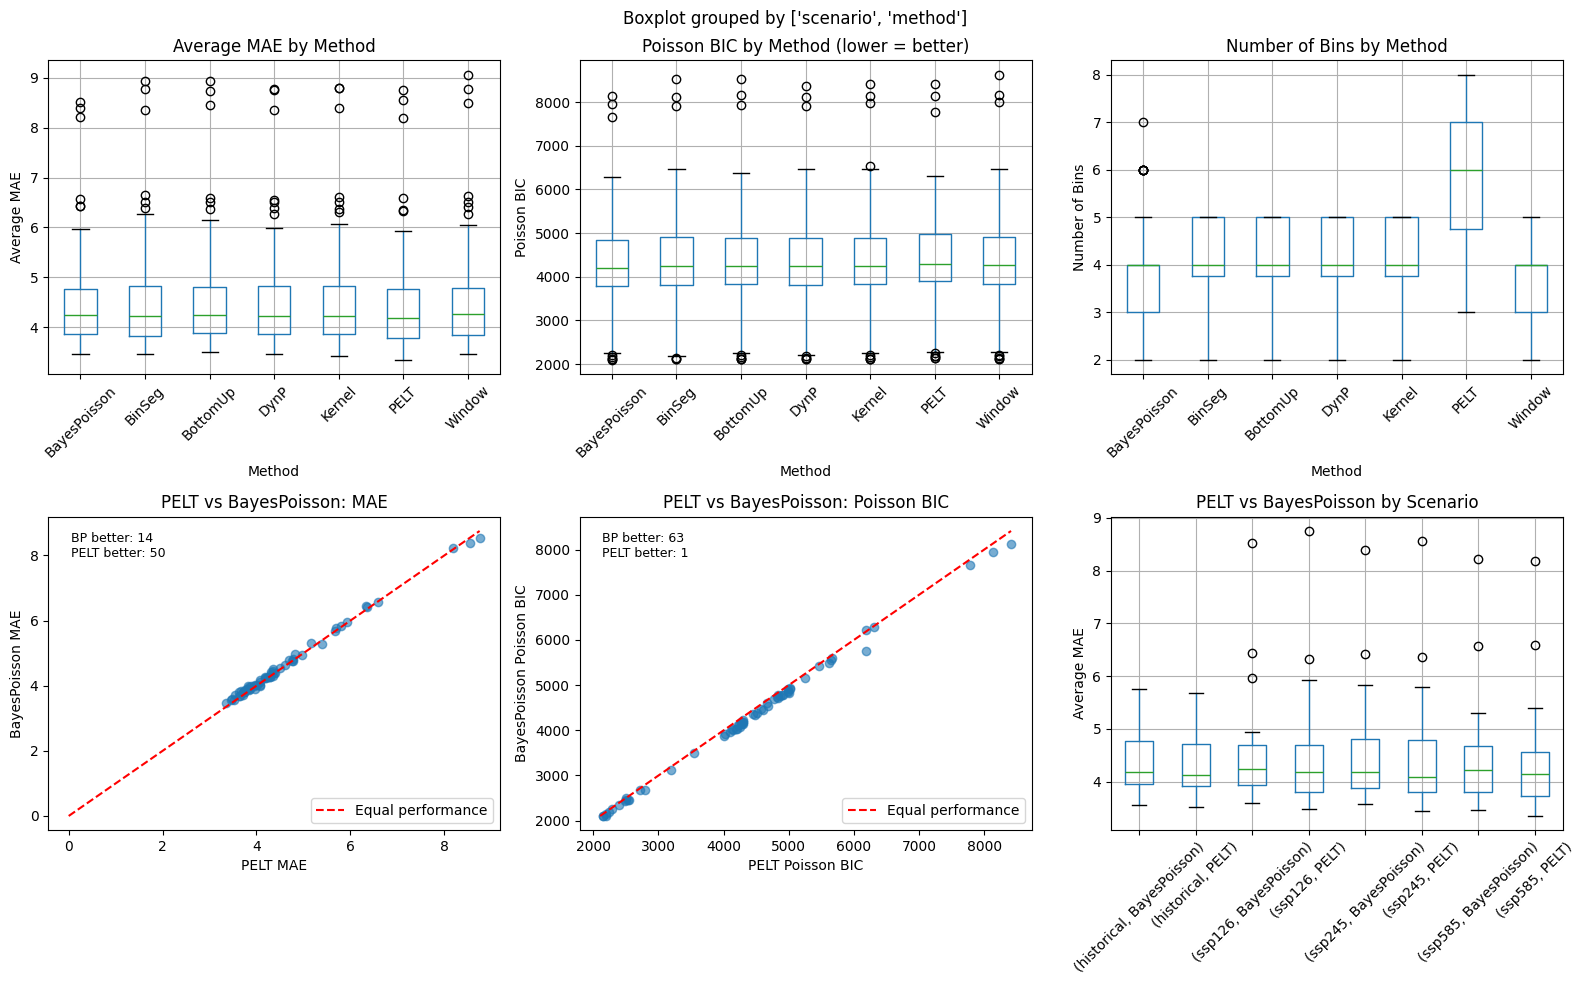


HEATMAP: Best method (lowest Poisson BIC) by Model × Scenario

Basin-specific scaling (by Poisson BIC):
scenario         historical        ssp126        ssp245        ssp585
model                                                                
CMCC-ESM2      BayesPoisson  BayesPoisson  BayesPoisson  BayesPoisson
EC-Earth3      BayesPoisson  BayesPoisson  BayesPoisson  BayesPoisson
MPI-ESM1-2-HR  BayesPoisson          PELT  BayesPoisson  BayesPoisson
MRI-ESM2-0     BayesPoisson  BayesPoisson  BayesPoisson  BayesPoisson

----------------------------------------
Best method (lowest MAE) by Model × Scenario
----------------------------------------

Basin-specific scaling (by MAE):
scenario         historical        ssp126        ssp245        ssp585
model                                                                
CMCC-ESM2              PELT  BayesPoisson  BayesPoisson          PELT
EC-Earth3      BayesPoisson          PELT          PELT          PELT
MPI-ESM1-2-HR          PELT      

In [7]:
# ============================================================================
# VISUALIZATION: Method comparison plots (PELT vs BayesPoisson focus)
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Average MAE by method (boxplot)
ax = axes[0, 0]
all_results.boxplot(column='avg_mae', by='method', ax=ax)
ax.set_title('Average MAE by Method')
ax.set_xlabel('Method')
ax.set_ylabel('Average MAE')
ax.tick_params(axis='x', rotation=45)
plt.suptitle('')

# 2. Poisson BIC by method (boxplot) - key for count data
ax = axes[0, 1]
all_results.boxplot(column='poisson_bic', by='method', ax=ax)
ax.set_title('Poisson BIC by Method (lower = better)')
ax.set_xlabel('Method')
ax.set_ylabel('Poisson BIC')
ax.tick_params(axis='x', rotation=45)

# 3. Number of bins by method
ax = axes[0, 2]
all_results.boxplot(column='n_bins', by='method', ax=ax)
ax.set_title('Number of Bins by Method')
ax.set_xlabel('Method')
ax.set_ylabel('Number of Bins')
ax.tick_params(axis='x', rotation=45)

# 4. PELT vs BayesPoisson MAE scatter
ax = axes[1, 0]
if len(comparison) > 0:
    ax.scatter(comparison['avg_mae_PELT'], comparison['avg_mae_BP'], alpha=0.6)
    max_val = max(comparison['avg_mae_PELT'].max(), comparison['avg_mae_BP'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', label='Equal performance')
    ax.set_xlabel('PELT MAE')
    ax.set_ylabel('BayesPoisson MAE')
    ax.set_title('PELT vs BayesPoisson: MAE')
    ax.legend()
    # Count points above/below line
    above = (comparison['avg_mae_BP'] < comparison['avg_mae_PELT']).sum()
    below = (comparison['avg_mae_BP'] > comparison['avg_mae_PELT']).sum()
    ax.text(0.05, 0.95, f'BP better: {above}\nPELT better: {below}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=9)

# 5. PELT vs BayesPoisson Poisson BIC scatter
ax = axes[1, 1]
if len(comparison) > 0:
    ax.scatter(comparison['poisson_bic_PELT'], comparison['poisson_bic_BP'], alpha=0.6)
    max_val = max(comparison['poisson_bic_PELT'].max(), comparison['poisson_bic_BP'].max())
    min_val = min(comparison['poisson_bic_PELT'].min(), comparison['poisson_bic_BP'].min())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equal performance')
    ax.set_xlabel('PELT Poisson BIC')
    ax.set_ylabel('BayesPoisson Poisson BIC')
    ax.set_title('PELT vs BayesPoisson: Poisson BIC')
    ax.legend()
    above = (comparison['poisson_bic_BP'] < comparison['poisson_bic_PELT']).sum()
    below = (comparison['poisson_bic_BP'] > comparison['poisson_bic_PELT']).sum()
    ax.text(0.05, 0.95, f'BP better: {above}\nPELT better: {below}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=9)

# 6. MAE by scenario
ax = axes[1, 2]
# Focus on PELT and BayesPoisson only
focus_methods = all_results[all_results['method'].isin(['PELT', 'BayesPoisson'])]
focus_methods.boxplot(column='avg_mae', by=['scenario', 'method'], ax=ax)
ax.set_title('PELT vs BayesPoisson by Scenario')
ax.set_xlabel('')
ax.set_ylabel('Average MAE')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Heatmap: Best method for each model/scenario combination
print("\n" + "=" * 80)
print("HEATMAP: Best method (lowest Poisson BIC) by Model × Scenario")
print("=" * 80)

# For basin-specific scaling
best_basin = best_by_poisson_bic[best_by_poisson_bic['scaling'] == 'scaled_basin'].pivot_table(
    index='model', columns='scenario', values='method', aggfunc='first'
)
print("\nBasin-specific scaling (by Poisson BIC):")
print(best_basin)

print("\n" + "-" * 40)
print("Best method (lowest MAE) by Model × Scenario")
print("-" * 40)
best_mae_basin = best_by_mae[best_by_mae['scaling'] == 'scaled_basin'].pivot_table(
    index='model', columns='scenario', values='method', aggfunc='first'
)
print("\nBasin-specific scaling (by MAE):")
print(best_mae_basin)

In [8]:
# # ============================================================================
# # DETAILED RESULTS: Show bin boundaries and means for best methods
# # ============================================================================

# print("=" * 80)
# print("DETAILED: Bin boundaries for best method per combination")
# print("=" * 80)

# # Show the best result for each model/variant/scenario/scaling
# for _, row in best_methods.iterrows():
#     model, variant, scenario, scaling = row['model'], row['variant'], row['scenario'], row['scaling']
#     method, n_bins, mae = row['method'], row['n_bins'], row['avg_mae']
#     breaks = row['breaks']
    
#     print(f"\n{model} / {variant} / {scenario} / {scaling}")
#     print(f"  Best method: {method} ({n_bins} bins, MAE={mae:.2f})")
#     print(f"  Breaks: {breaks}")

# # Create a clean summary table of breaks
# print("\n" + "=" * 80)
# print("SUMMARY TABLE: Year bins by model/variant/scenario (best method, basin-specific scaling)")
# print("=" * 80)

# summary_rows = []
# for _, row in best_methods[best_methods['scaling'] == 'scaled_basin'].iterrows():
#     breaks = row['breaks']
#     bin_ranges = []
#     for i in range(len(breaks) - 1):
#         bin_ranges.append(f"{breaks[i]}-{breaks[i+1]}")
    
#     summary_rows.append({
#         'model': row['model'],
#         'variant': row['variant'], 
#         'scenario': row['scenario'],
#         'method': row['method'],
#         'n_bins': row['n_bins'],
#         'avg_mae': round(row['avg_mae'], 2),
#         'bin_ranges': ' | '.join(bin_ranges)
#     })

# summary_table = pd.DataFrame(summary_rows)
# print(summary_table.to_string(index=False))

In [9]:
# ============================================================================
# INTERACTIVE: Visualize specific model/variant/scenario combinations
# ============================================================================

def plot_detection(model, variant, scenario, scaling='scaled_basin', method=None):
    """
    Plot the bin detection for a specific combination.
    If method is None, uses the best method (lowest MAE).
    """
    key = (model, variant, scenario, scaling)
    if key not in all_detectors:
        print(f"No detector found for {key}")
        print(f"Available keys: {list(all_detectors.keys())[:5]}...")
        return
    
    detector = all_detectors[key]
    
    if method is None:
        method, _ = detector.select_best_method(criterion='avg_mae')
    
    if method not in detector.results:
        print(f"Method {method} not found. Available: {list(detector.results.keys())}")
        return
    
    print(f"Plotting: {model} / {variant} / {scenario} / {scaling}")
    print(f"Method: {method}")
    
    fig = detector.plot_all_basins(method)
    plt.show()
    
    # Also print the bin means (rounded to integers)
    metrics = detector._compute_fit_metrics(detector.results[method])
    print(f"\nBin summary (constant integer approximations per basin):")
    for bin_info in metrics['bins']:
        print(f"  {bin_info['start_year']}-{bin_info['end_year']} ({bin_info['size']} years):")
        for basin, mean_val in bin_info['basin_means'].items():
            mae = bin_info['basin_mae'].get(basin, 0)
            print(f"    {basin}: {mean_val:.1f} (rounded: {int(round(mean_val))}, MAE: {mae:.2f})")

# Example usage - plot a specific combination
# Uncomment and modify to explore different combinations:

# plot_detection('MPI-ESM1-2-HR', 'r1i1p1f1', 'ssp126', 'scaled_basin')
# plot_detection('MRI-ESM2-0', 'r1i1p1f1', 'historical', 'scaled_basin')

# Or compare methods for a specific combination:
# key = ('MPI-ESM1-2-HR', 'r1i1p1f1', 'ssp126', 'scaled_basin')
# if key in all_detectors:
#     detector = all_detectors[key]
#     for method in detector.results.keys():
#         detector.plot_all_basins(method)
#         plt.show()

print("Use plot_detection(model, variant, scenario, scaling, method) to visualize specific combinations.")
print(f"Available combinations: {len(all_detectors)}")

Use plot_detection(model, variant, scenario, scaling, method) to visualize specific combinations.
Available combinations: 64



Plotting: MPI-ESM1-2-HR / r1i1p1f1 / historical / scaled_basin
Method: PELT


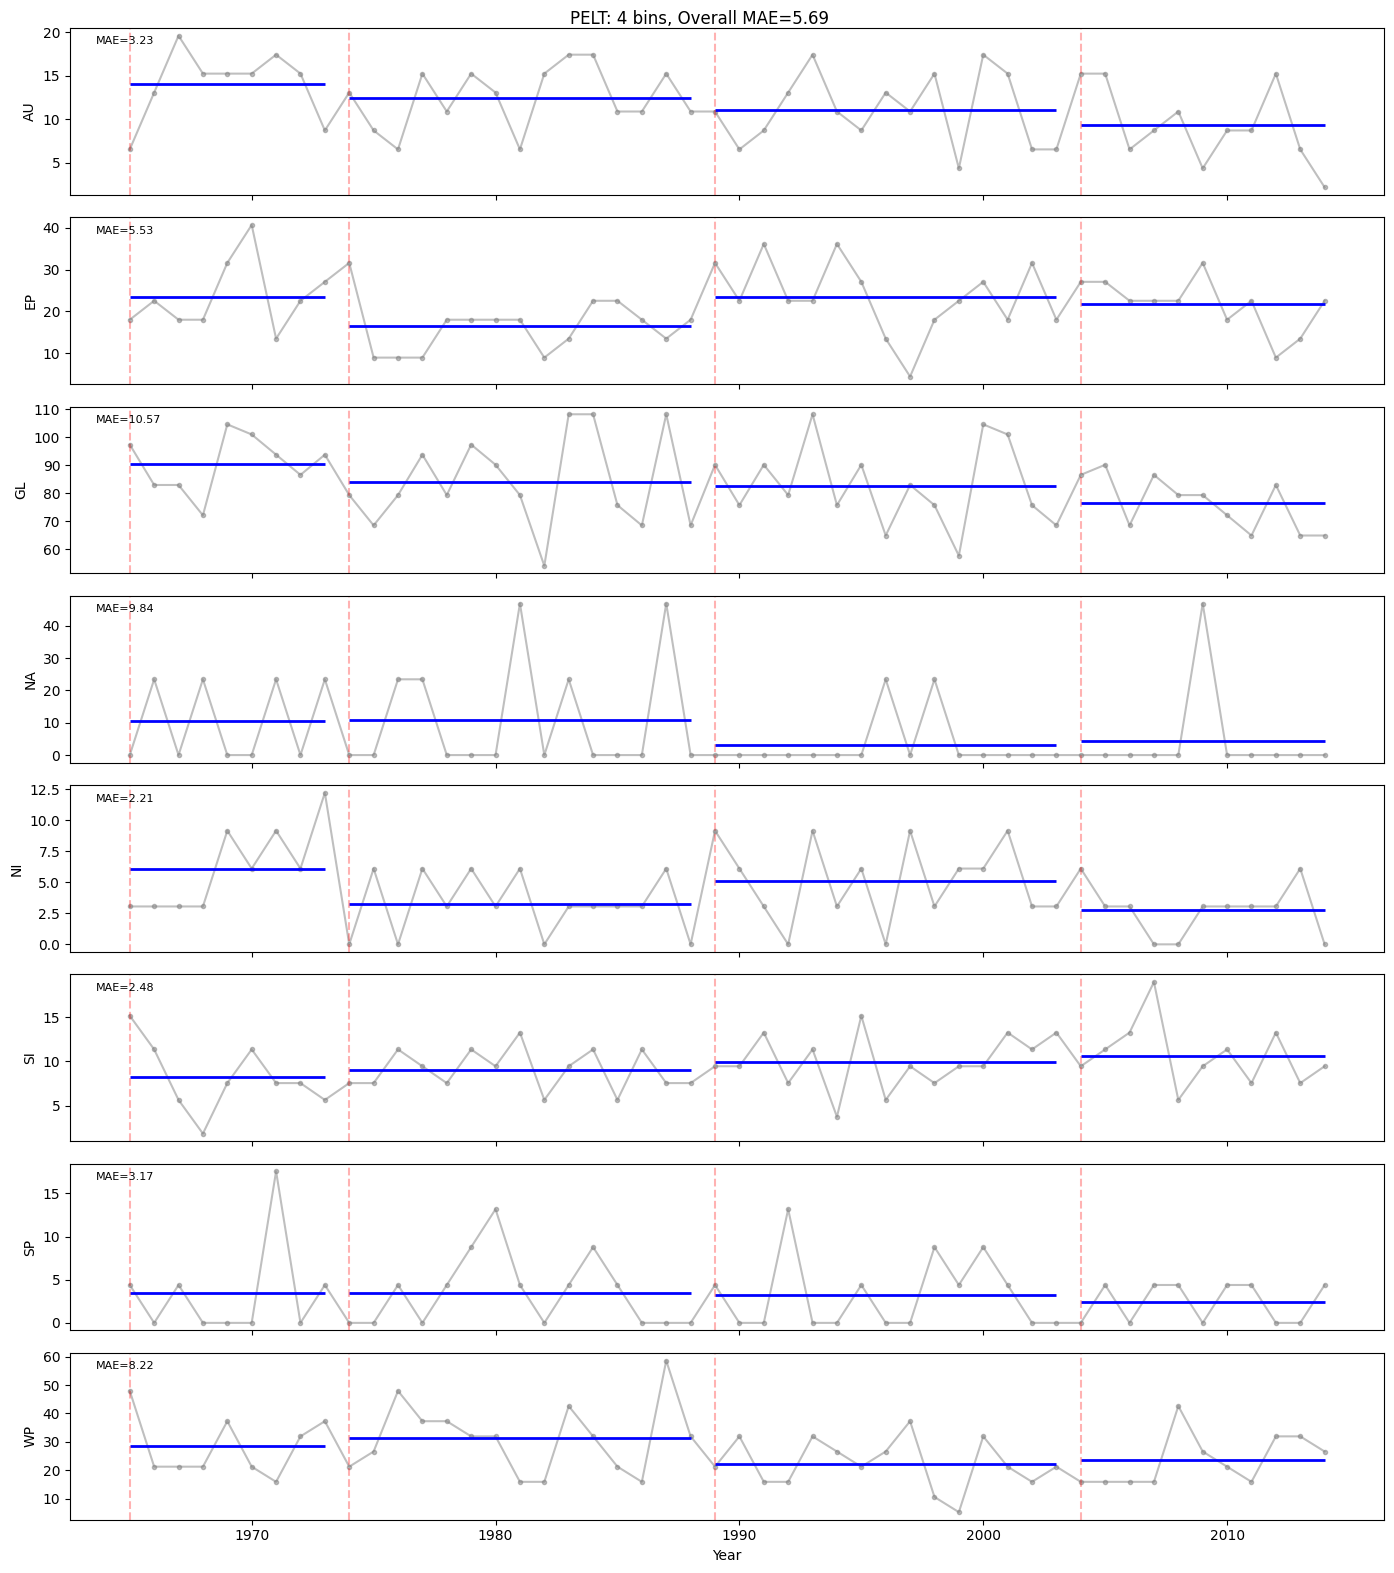


Bin summary (constant integer approximations per basin):
  1965-1973 (9 years):
    AU: 14.0 (rounded: 14, MAE: 3.07)
    EP: 23.6 (rounded: 24, MAE: 6.35)
    GL: 90.6 (rounded: 91, MAE: 8.37)
    NA: 10.4 (rounded: 10, MAE: 11.59)
    NI: 6.1 (rounded: 6, MAE: 2.72)
    SI: 8.2 (rounded: 8, MAE: 2.94)
    SP: 3.4 (rounded: 3, MAE: 3.79)
    WP: 28.4 (rounded: 28, MAE: 9.07)
  1974-1988 (15 years):
    AU: 12.5 (rounded: 12, MAE: 2.95)
    EP: 16.5 (rounded: 17, MAE: 4.81)
    GL: 83.9 (rounded: 84, MAE: 13.66)
    NA: 11.0 (rounded: 11, MAE: 14.60)
    NI: 3.3 (rounded: 3, MAE: 1.90)
    SI: 9.1 (rounded: 9, MAE: 1.92)
    SP: 3.5 (rounded: 4, MAE: 3.28)
    WP: 31.2 (rounded: 31, MAE: 9.37)
  1989-2003 (15 years):
    AU: 11.0 (rounded: 11, MAE: 3.37)
    EP: 23.5 (rounded: 23, MAE: 6.50)
    GL: 82.7 (rounded: 83, MAE: 11.77)
    NA: 3.1 (rounded: 3, MAE: 5.42)
    NI: 5.1 (rounded: 5, MAE: 2.72)
    SI: 10.0 (rounded: 10, MAE: 2.37)
    SP: 3.2 (rounded: 3, MAE: 3.43)
    WP: 22.

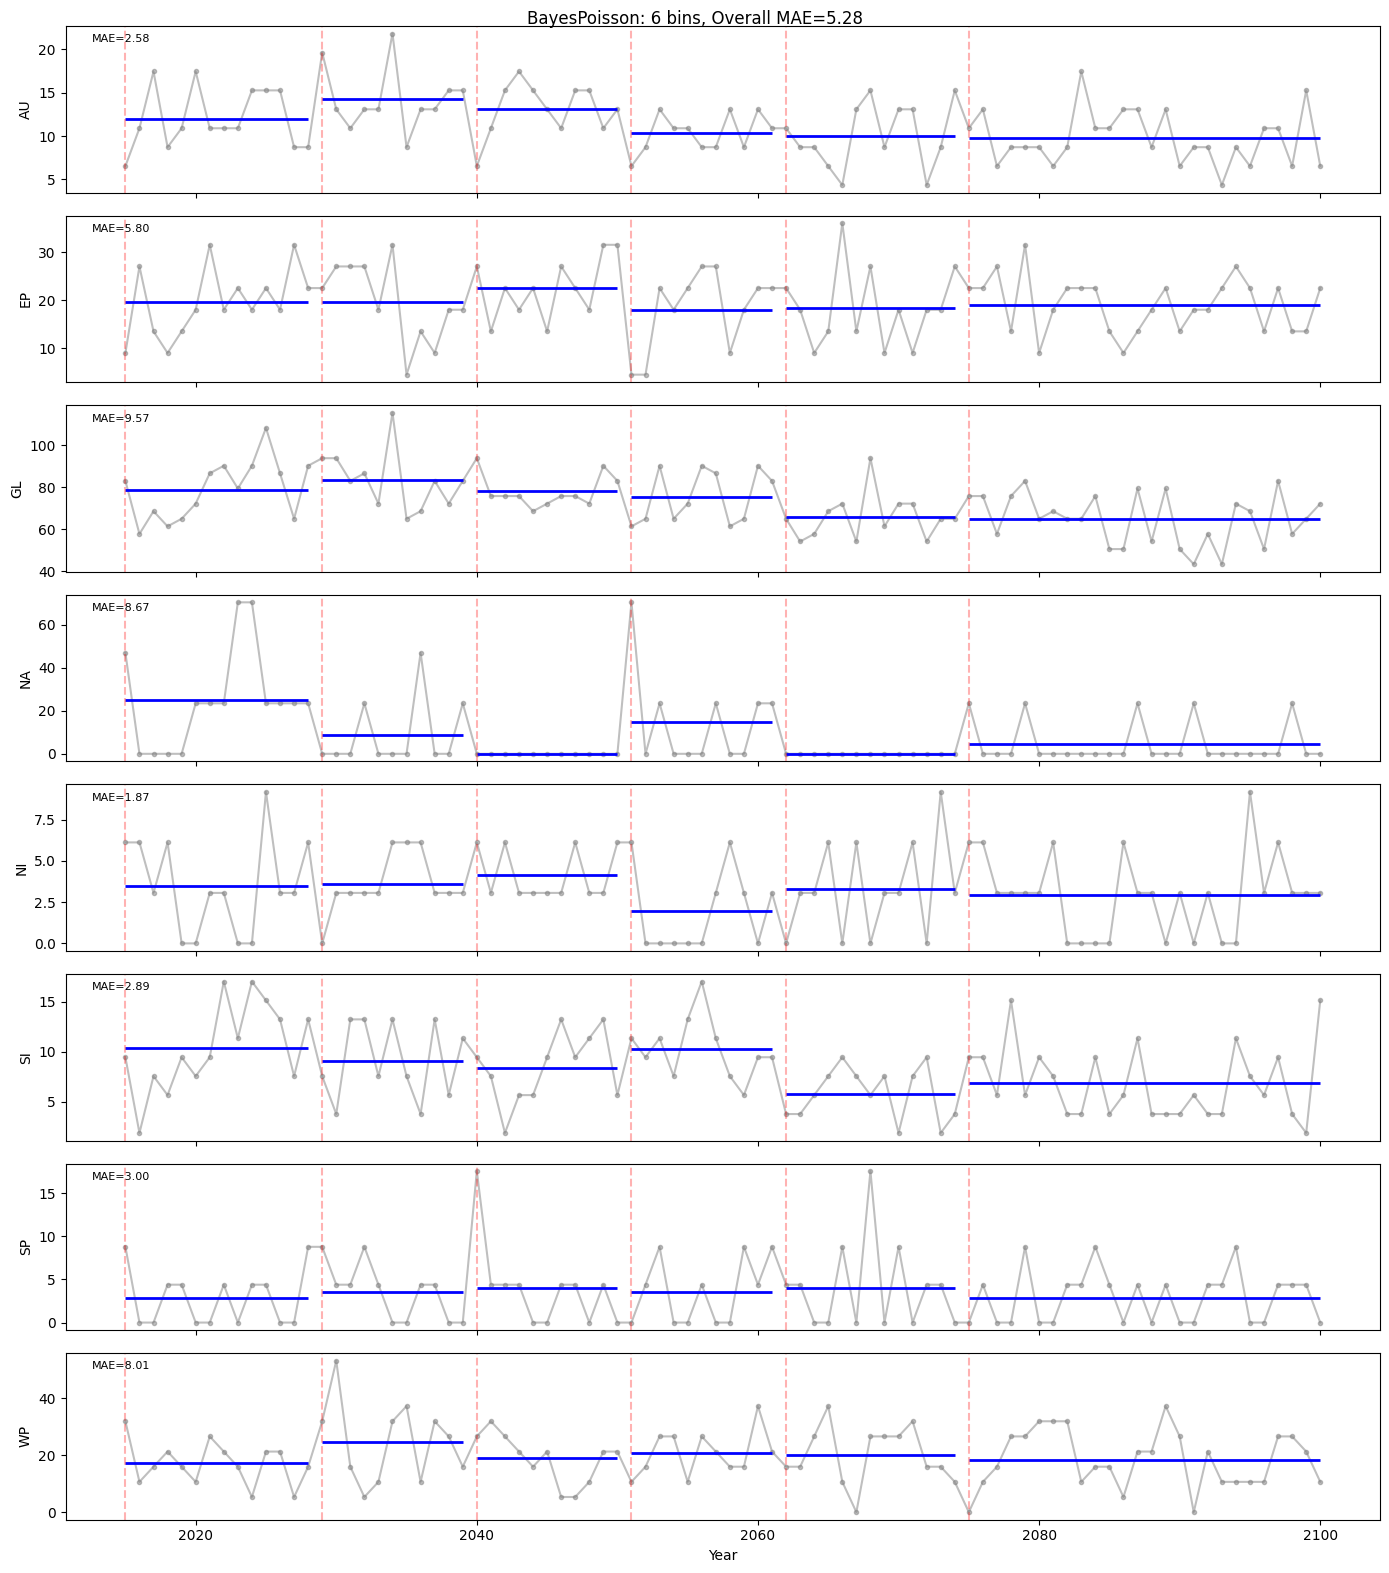


Bin summary (constant integer approximations per basin):
  2015-2028 (14 years):
    AU: 12.0 (rounded: 12, MAE: 2.96)
    EP: 19.7 (rounded: 20, MAE: 5.71)
    GL: 78.8 (rounded: 79, MAE: 11.92)
    NA: 25.1 (rounded: 25, MAE: 16.04)
    NI: 3.5 (rounded: 3, MAE: 2.31)
    SI: 10.4 (rounded: 10, MAE: 3.52)
    SP: 2.8 (rounded: 3, MAE: 2.82)
    WP: 17.1 (rounded: 17, MAE: 5.87)
  2029-2039 (11 years):
    AU: 14.3 (rounded: 14, MAE: 2.70)
    EP: 19.7 (rounded: 20, MAE: 6.71)
    GL: 83.3 (rounded: 83, MAE: 10.25)
    NA: 8.5 (rounded: 9, MAE: 12.41)
    NI: 3.6 (rounded: 4, MAE: 1.36)
    SI: 9.1 (rounded: 9, MAE: 3.41)
    SP: 3.6 (rounded: 4, MAE: 2.61)
    WP: 24.7 (rounded: 25, MAE: 11.80)
  2040-2050 (11 years):
    AU: 13.1 (rounded: 13, MAE: 2.38)
    EP: 22.6 (rounded: 23, MAE: 4.92)
    GL: 78.0 (rounded: 78, MAE: 5.96)
    NA: 0.0 (rounded: 0, MAE: 0.00)
    NI: 4.2 (rounded: 4, MAE: 1.42)
    SI: 8.4 (rounded: 8, MAE: 2.85)
    SP: 4.0 (rounded: 4, MAE: 2.90)
    WP: 18.

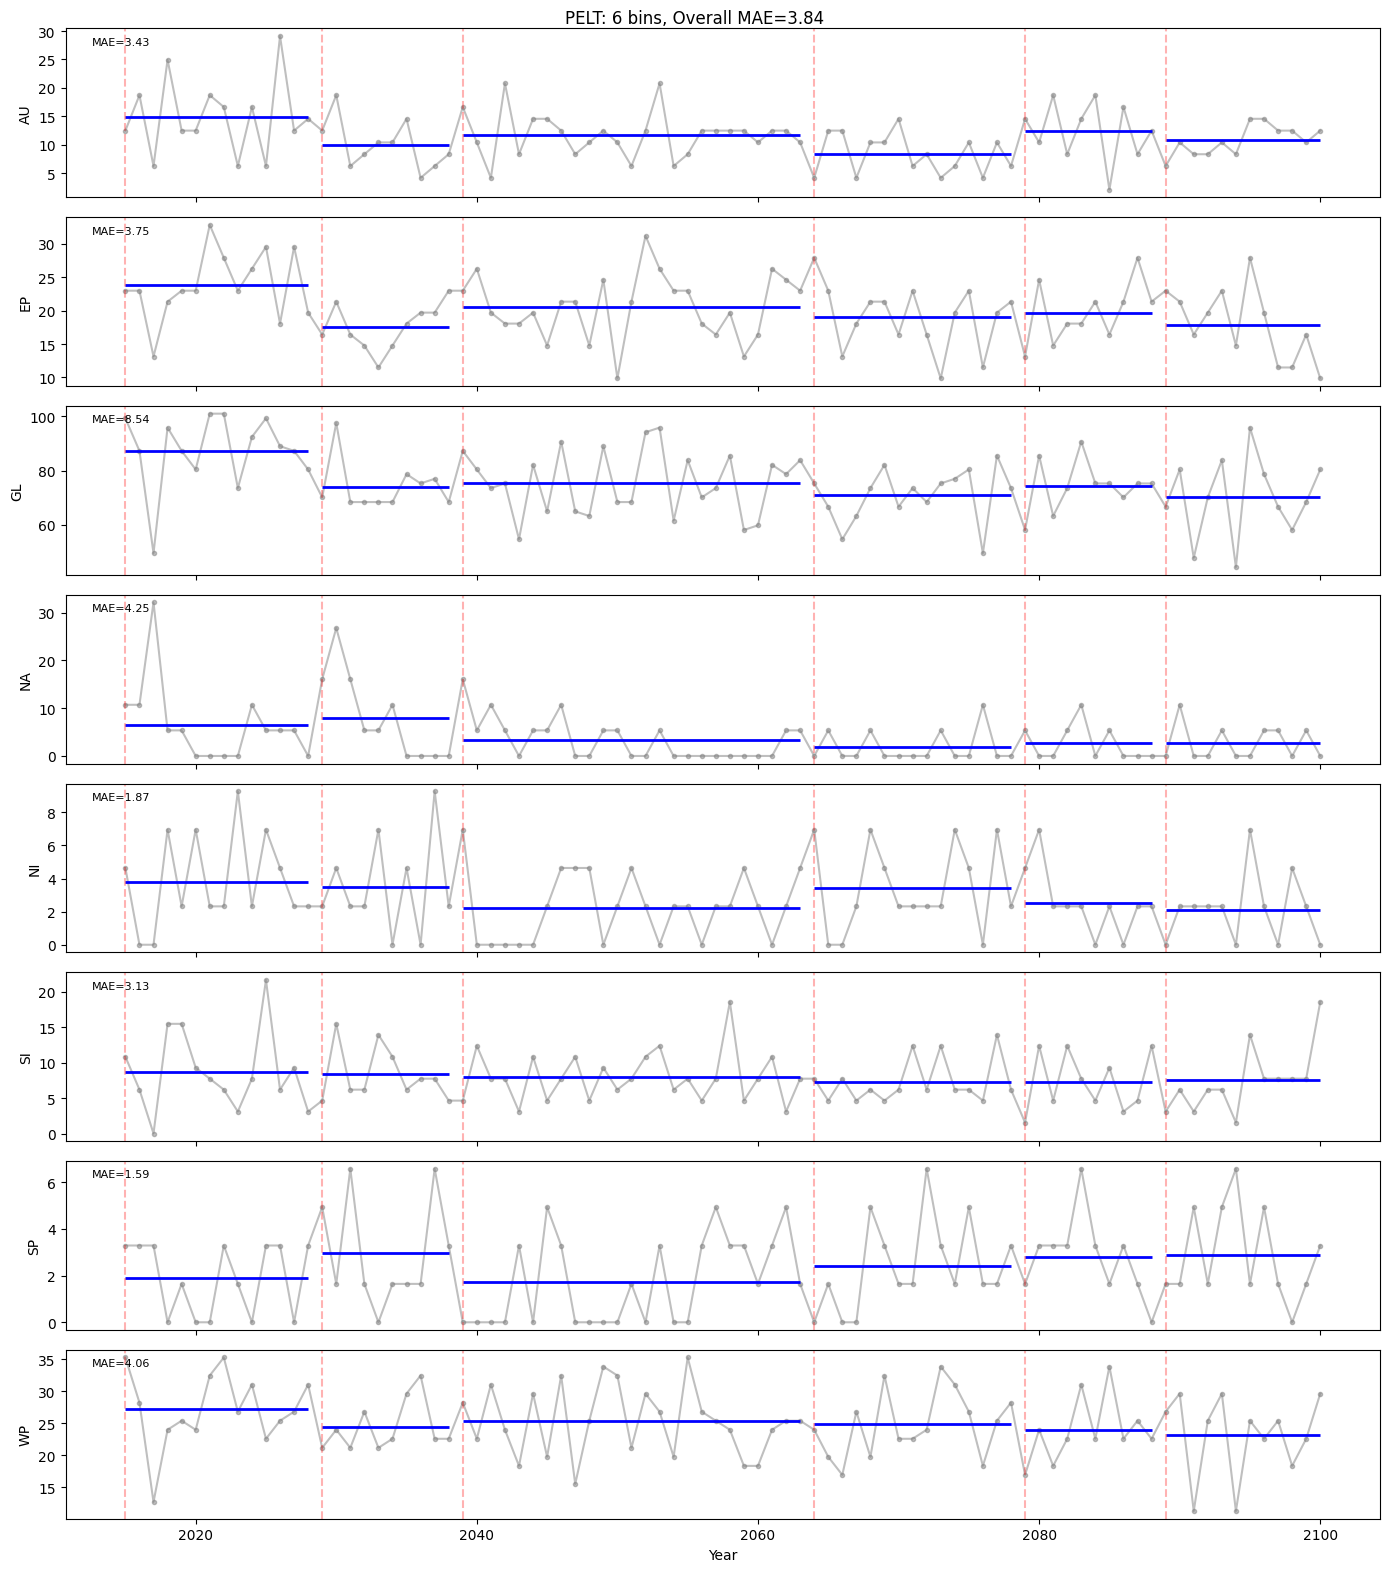


Bin summary (constant integer approximations per basin):
  2015-2028 (14 years):
    AU: 14.9 (rounded: 15, MAE: 5.09)
    EP: 23.8 (rounded: 24, MAE: 3.87)
    GL: 87.3 (rounded: 87, MAE: 9.41)
    NA: 6.5 (rounded: 7, MAE: 5.47)
    NI: 3.8 (rounded: 4, MAE: 2.37)
    SI: 8.7 (rounded: 9, MAE: 4.23)
    SP: 1.9 (rounded: 2, MAE: 1.41)
    WP: 27.2 (rounded: 27, MAE: 4.29)
  2029-2038 (10 years):
    AU: 10.0 (rounded: 10, MAE: 3.33)
    EP: 17.6 (rounded: 18, MAE: 2.79)
    GL: 74.1 (rounded: 74, MAE: 6.43)
    NA: 8.0 (rounded: 8, MAE: 7.50)
    NI: 3.5 (rounded: 3, MAE: 2.32)
    SI: 8.3 (rounded: 8, MAE: 3.03)
    SP: 3.0 (rounded: 3, MAE: 1.91)
    WP: 24.4 (rounded: 24, MAE: 3.13)
  2039-2063 (25 years):
    AU: 11.7 (rounded: 12, MAE: 2.84)
    EP: 20.6 (rounded: 21, MAE: 3.84)
    GL: 75.6 (rounded: 76, MAE: 10.07)
    NA: 3.4 (rounded: 3, MAE: 3.56)
    NI: 2.2 (rounded: 2, MAE: 1.60)
    SI: 8.0 (rounded: 8, MAE: 2.56)
    SP: 1.7 (rounded: 2, MAE: 1.66)
    WP: 25.3 (round

In [10]:
# ============================================================================
# EXAMPLE PLOTS: Visualize a few combinations
# ============================================================================

# Plot 3 example combinations to show the binning results

examples = [
    ('MPI-ESM1-2-HR', 'r1i1p1f1', 'historical', 'scaled_basin'),
    ('MPI-ESM1-2-HR', 'r1i1p1f1', 'ssp585', 'scaled_basin'),
    ('MRI-ESM2-0', 'r1i1p1f1', 'ssp245', 'scaled_basin'),
]

for model, variant, scenario, scaling in examples:
    key = (model, variant, scenario, scaling)
    if key in all_detectors:
        print("\n" + "=" * 80)
        plot_detection(model, variant, scenario, scaling)
        print("=" * 80)

PELT RESULTS: Recommended Method for Time Bin Detection

Reference:
  Killick, R., Fearnhead, P., & Eckley, I. A. (2012).
  'Optimal Detection of Changepoints With a Linear Computational Cost.'
  Journal of the American Statistical Association, 107(500), 1590-1598.
  DOI: 10.1080/01621459.2012.737745

PELT Summary Statistics:
  Average MAE: 4.518 ± 1.166
  Average # bins: 5.7
  Total combinations analyzed: 64

----------------------------------------
PELT by Scaling Approach:
----------------------------------------
  scaled_basin: MAE = 4.890 ± 1.327
  scaled_global: MAE = 4.146 ± 0.847

----------------------------------------
PELT by Scenario:
----------------------------------------
  historical: MAE = 4.328, avg bins = 3.6
  ssp126: MAE = 4.637, avg bins = 6.2
  ssp245: MAE = 4.574, avg bins = 6.6
  ssp585: MAE = 4.533, avg bins = 6.4

FINAL RECOMMENDED TIME BINS (PELT, Basin-Specific Scaling)
        Model  Variant   Scenario  N_Bins  MAE                                          

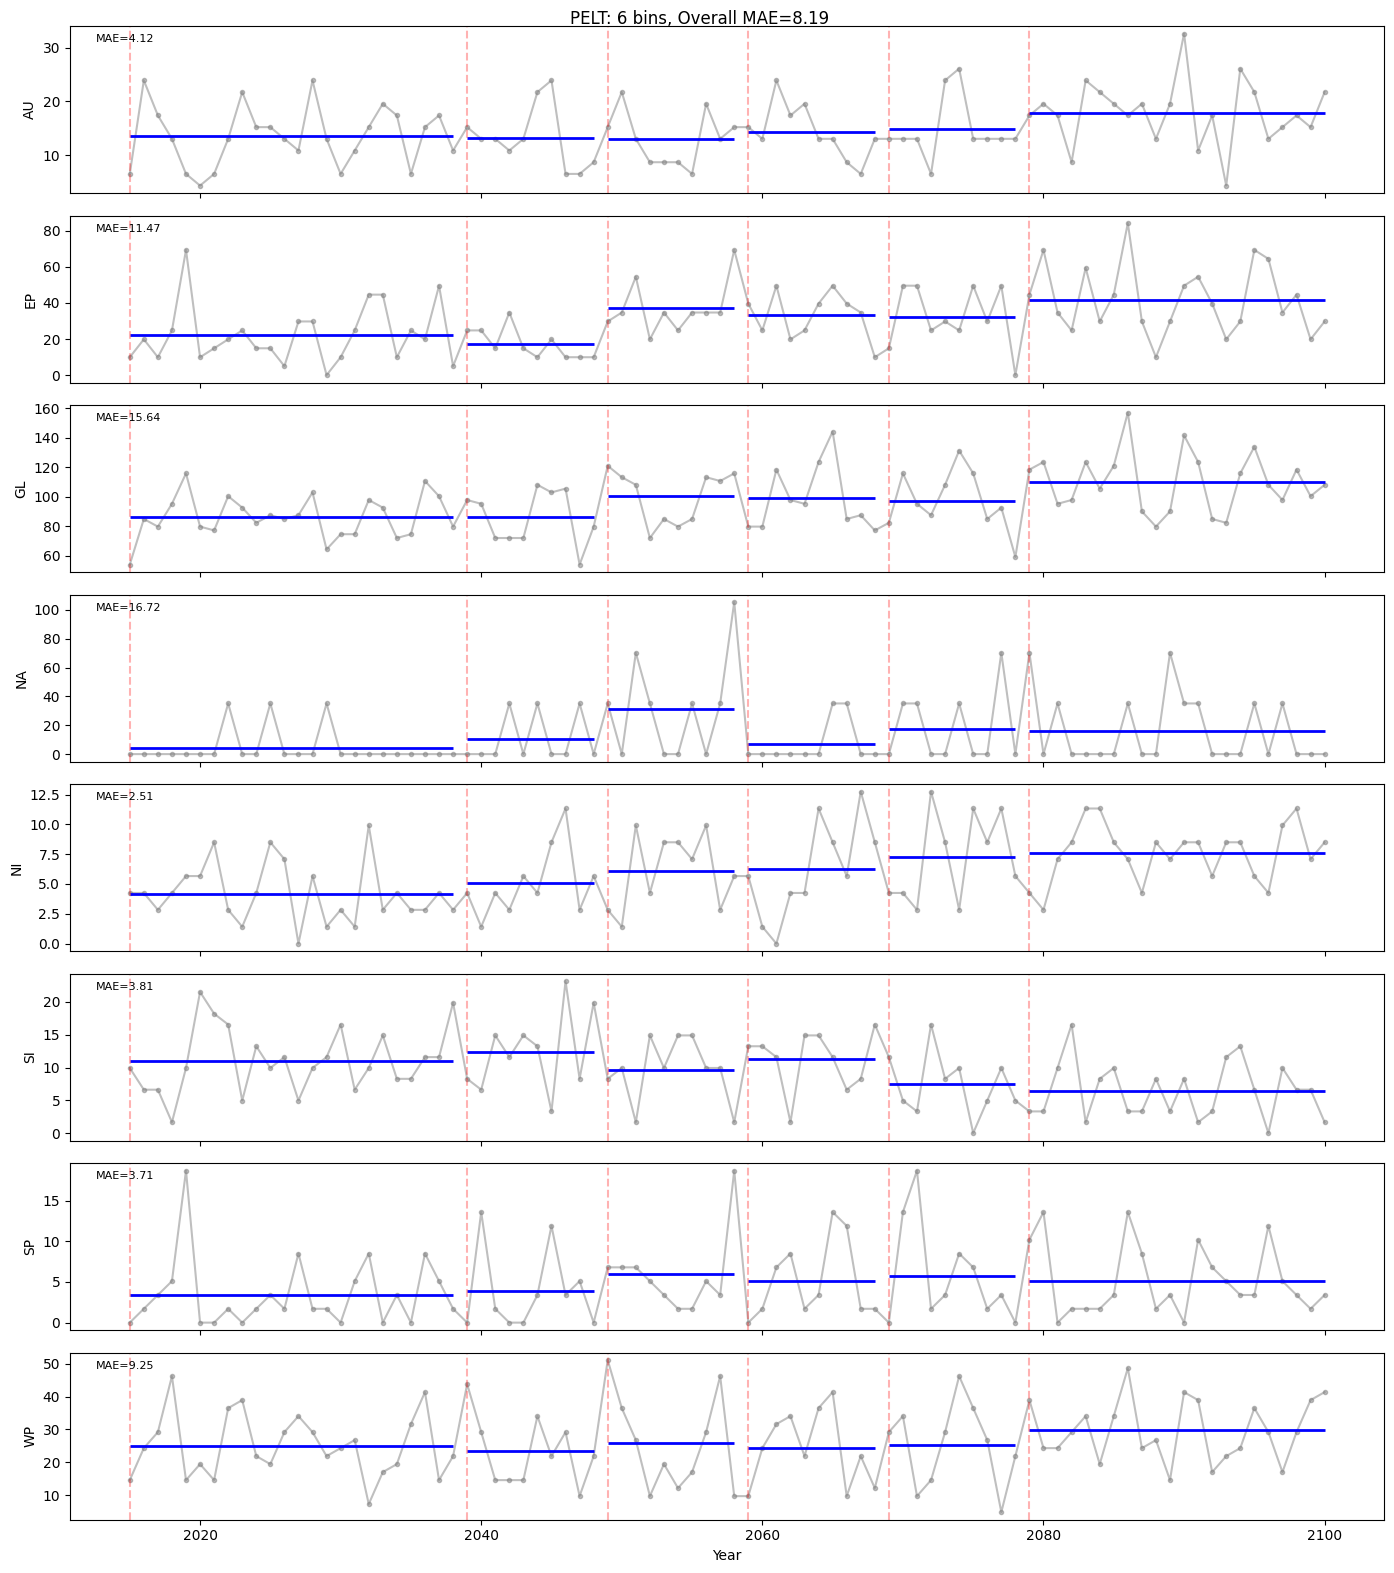

Bin means (rounded to integers for use as constants):
  2015-2038: AU:13, EP:22, GL:86, NA:4, NI:4, SI:11, SP:3, WP:25
  2039-2048: AU:13, EP:17, GL:86, NA:11, NI:5, SI:12, SP:4, WP:23
  2049-2058: AU:13, EP:37, GL:100, NA:32, NI:6, SI:10, SP:6, WP:26
  2059-2068: AU:14, EP:33, GL:99, NA:7, NI:6, SI:11, SP:5, WP:24
  2069-2078: AU:15, EP:32, GL:97, NA:18, NI:7, SI:7, SP:6, WP:25
  2079-2100: AU:18, EP:42, GL:110, NA:16, NI:8, SI:6, SP:5, WP:30

EC-Earth3 / r1i1p1f1 / ssp585


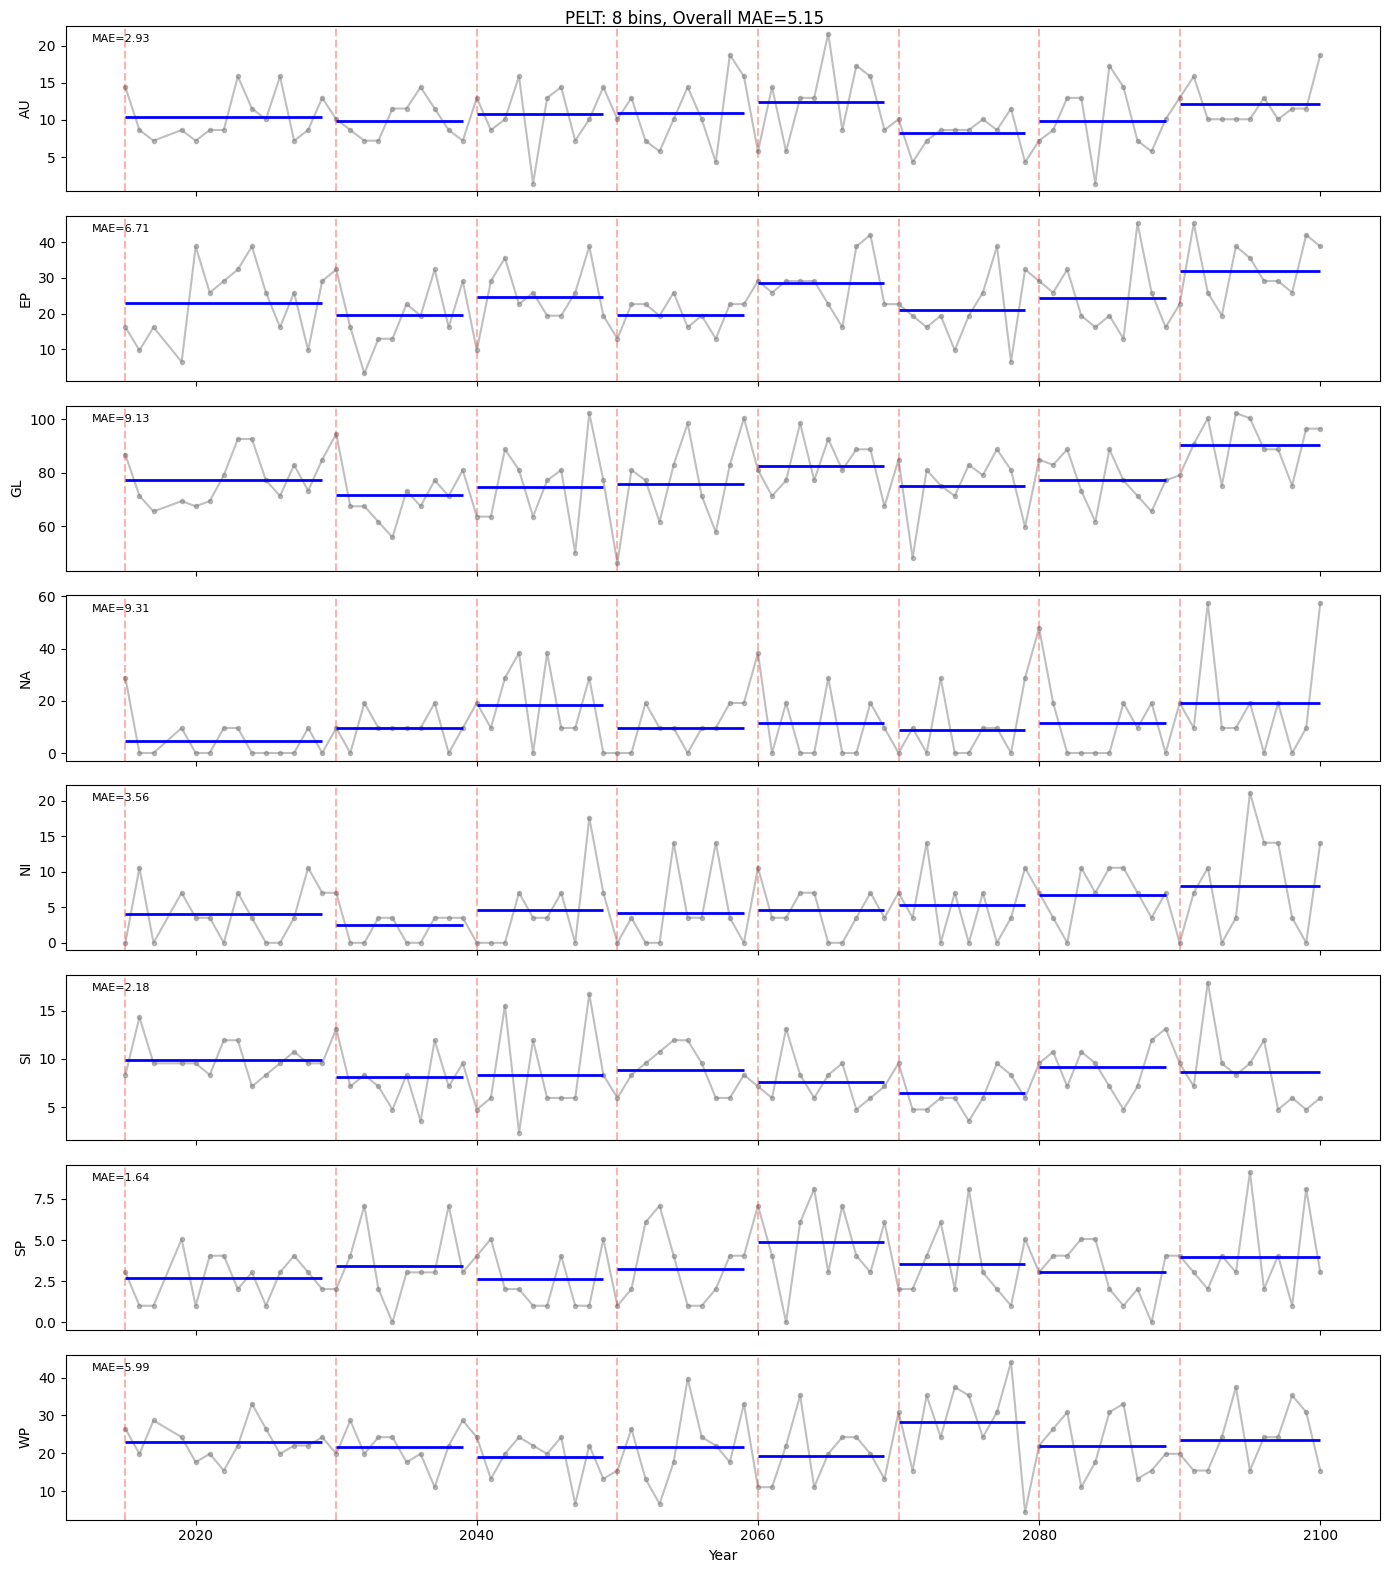

Bin means (rounded to integers for use as constants):
  2015-2029: AU:10, EP:23, GL:77, NA:5, NI:4, SI:10, SP:3, WP:23
  2030-2039: AU:10, EP:20, GL:72, NA:10, NI:2, SI:8, SP:3, WP:22
  2040-2049: AU:11, EP:25, GL:75, NA:18, NI:5, SI:8, SP:3, WP:19
  2050-2059: AU:11, EP:20, GL:76, NA:10, NI:4, SI:9, SP:3, WP:22
  2060-2069: AU:12, EP:28, GL:82, NA:11, NI:5, SI:8, SP:5, WP:19
  2070-2079: AU:8, EP:21, GL:75, NA:9, NI:5, SI:6, SP:4, WP:28
  2080-2089: AU:10, EP:24, GL:77, NA:11, NI:7, SI:9, SP:3, WP:22
  2090-2100: AU:12, EP:32, GL:90, NA:19, NI:8, SI:9, SP:4, WP:23

MPI-ESM1-2-HR / r1i1p1f1 / ssp585


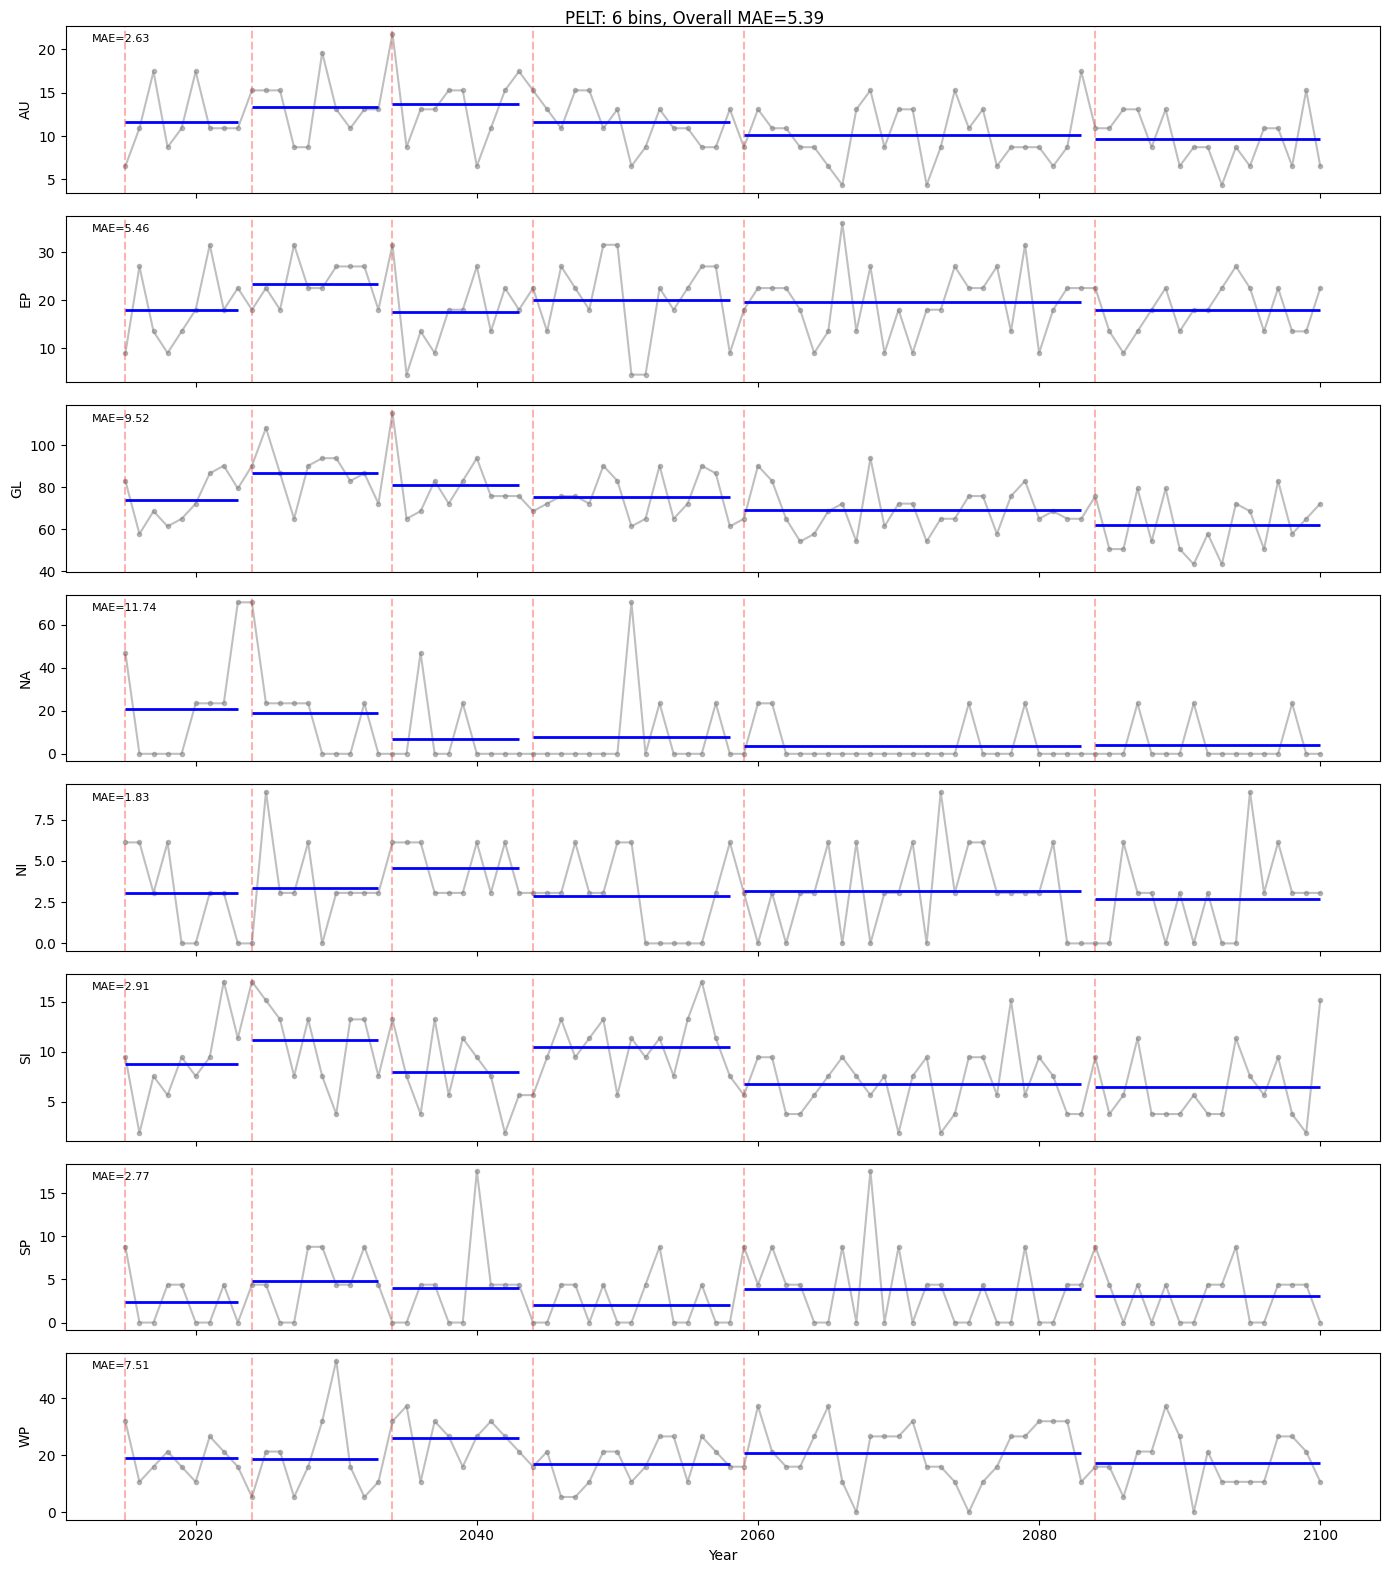

Bin means (rounded to integers for use as constants):
  2015-2023: AU:12, EP:18, GL:74, NA:21, NI:3, SI:9, SP:2, WP:19
  2024-2033: AU:13, EP:23, GL:87, NA:19, NI:3, SI:11, SP:5, WP:19
  2034-2043: AU:14, EP:18, GL:81, NA:7, NI:5, SI:8, SP:4, WP:26
  2044-2058: AU:12, EP:20, GL:75, NA:8, NI:3, SI:10, SP:2, WP:17
  2059-2083: AU:10, EP:20, GL:69, NA:4, NI:3, SI:7, SP:4, WP:21
  2084-2100: AU:10, EP:18, GL:62, NA:4, NI:3, SI:6, SP:3, WP:17

MRI-ESM2-0 / r1i1p1f1 / ssp585


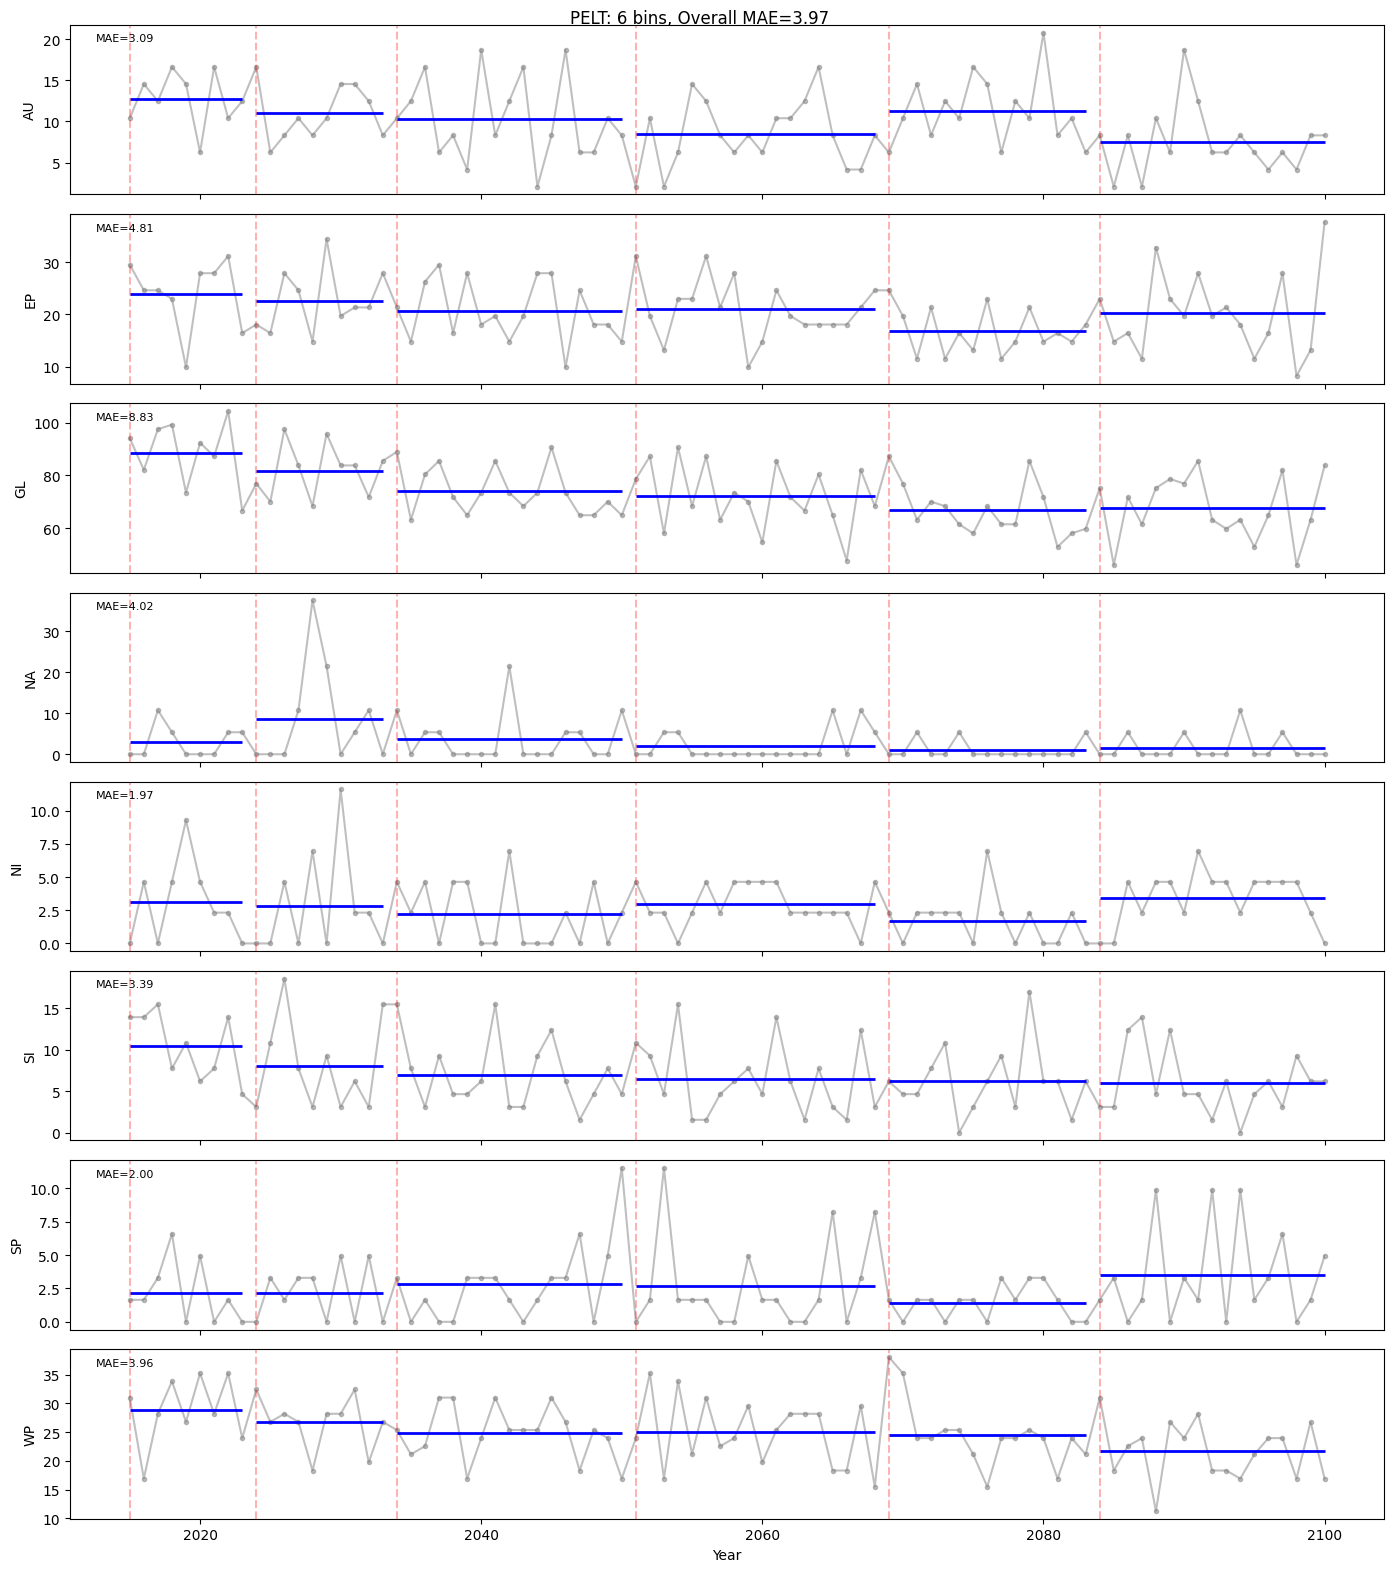

Bin means (rounded to integers for use as constants):
  2015-2023: AU:13, EP:24, GL:89, NA:3, NI:3, SI:10, SP:2, WP:29
  2024-2033: AU:11, EP:23, GL:82, NA:9, NI:3, SI:8, SP:2, WP:27
  2034-2050: AU:10, EP:21, GL:74, NA:4, NI:2, SI:7, SP:3, WP:25
  2051-2068: AU:8, EP:21, GL:72, NA:2, NI:3, SI:6, SP:3, WP:25
  2069-2083: AU:11, EP:17, GL:67, NA:1, NI:2, SI:6, SP:1, WP:25
  2084-2100: AU:7, EP:20, GL:68, NA:2, NI:3, SI:6, SP:3, WP:22


In [11]:
# ============================================================================
# PELT FOCUS: Recommended method for publication
# ============================================================================
# 
# Method: PELT (Pruned Exact Linear Time)
# Citation: Killick, R., Fearnhead, P., & Eckley, I. A. (2012). 
#           "Optimal Detection of Changepoints With a Linear Computational Cost."
#           Journal of the American Statistical Association, 107(500), 1590-1598.
#           https://doi.org/10.1080/01621459.2012.737745
#
# Why PELT:
# - Statistically optimal: minimizes penalized cost function
# - Does not require pre-specifying number of change points
# - Linear computational complexity O(n)
# - Well-established in climate science literature
# ============================================================================

print("=" * 80)
print("PELT RESULTS: Recommended Method for Time Bin Detection")
print("=" * 80)
print("\nReference:")
print("  Killick, R., Fearnhead, P., & Eckley, I. A. (2012).")
print("  'Optimal Detection of Changepoints With a Linear Computational Cost.'")
print("  Journal of the American Statistical Association, 107(500), 1590-1598.")
print("  DOI: 10.1080/01621459.2012.737745")
print("=" * 80)

# Filter to PELT results only
pelt_results = all_results[all_results['method'] == 'PELT'].copy()

print(f"\nPELT Summary Statistics:")
print(f"  Average MAE: {pelt_results['avg_mae'].mean():.3f} ± {pelt_results['avg_mae'].std():.3f}")
print(f"  Average # bins: {pelt_results['n_bins'].mean():.1f}")
print(f"  Total combinations analyzed: {len(pelt_results)}")

# PELT results by scaling approach
print("\n" + "-" * 40)
print("PELT by Scaling Approach:")
print("-" * 40)
for scaling in ['scaled_basin', 'scaled_global']:
    subset = pelt_results[pelt_results['scaling'] == scaling]
    print(f"  {scaling}: MAE = {subset['avg_mae'].mean():.3f} ± {subset['avg_mae'].std():.3f}")

# PELT results by scenario
print("\n" + "-" * 40)
print("PELT by Scenario:")
print("-" * 40)
for scenario in scenarios:
    subset = pelt_results[pelt_results['scenario'] == scenario]
    if len(subset) > 0:
        print(f"  {scenario}: MAE = {subset['avg_mae'].mean():.3f}, avg bins = {subset['n_bins'].mean():.1f}")

# Final recommended bins table (PELT, basin-specific scaling)
print("\n" + "=" * 80)
print("FINAL RECOMMENDED TIME BINS (PELT, Basin-Specific Scaling)")
print("=" * 80)

pelt_basin = pelt_results[pelt_results['scaling'] == 'scaled_basin'].copy()

final_bins = []
for _, row in pelt_basin.iterrows():
    breaks = row['breaks']
    bin_ranges = [f"{breaks[i]}-{breaks[i+1]}" for i in range(len(breaks)-1)]
    
    final_bins.append({
        'Model': row['model'],
        'Variant': row['variant'],
        'Scenario': row['scenario'],
        'N_Bins': row['n_bins'],
        'MAE': round(row['avg_mae'], 2),
        'Year_Bins': ' | '.join(bin_ranges)
    })

final_bins_df = pd.DataFrame(final_bins)
print(final_bins_df.to_string(index=False))

# Plot all PELT results for basin-specific scaling
print("\n" + "=" * 80)
print("PELT VISUALIZATIONS")
print("=" * 80)

# Select a subset to plot (one per model for ssp585)
plot_examples = [
    ('CMCC-ESM2', 'r1i1p1f1', 'ssp585'),
    ('EC-Earth3', 'r1i1p1f1', 'ssp585'),
    ('MPI-ESM1-2-HR', 'r1i1p1f1', 'ssp585'),
    ('MRI-ESM2-0', 'r1i1p1f1', 'ssp585'),
]

for model, variant, scenario in plot_examples:
    key = (model, variant, scenario, 'scaled_basin')
    if key in all_detectors:
        detector = all_detectors[key]
        if 'PELT' in detector.results:
            print(f"\n{model} / {variant} / {scenario}")
            fig = detector.plot_all_basins('PELT')
            plt.show()
            
            # Print the integer approximations
            metrics = detector._compute_fit_metrics(detector.results['PELT'])
            print(f"Bin means (rounded to integers for use as constants):")
            for bin_info in metrics['bins']:
                means_str = ", ".join([f"{b}:{int(round(m))}" for b, m in bin_info['basin_means'].items()])
                print(f"  {bin_info['start_year']}-{bin_info['end_year']}: {means_str}")

In [12]:
# ============================================================================
# EXPORT: Save bins to CSV file using recommended method
# ============================================================================
# Uses the recommended_method variable from the comparison cell above.
# Creates CSV files with bin definitions for all model/variant/scenario
# combinations using basin-specific scaling.
#
# Output columns:
#   - model, variant, scenario: identifiers
#   - method: the method used (PELT or BayesPoisson)
#   - bin_idx: bin number (0-indexed)
#   - start_year, end_year: bin boundaries
#   - bin_size: number of years in bin
#   - basin: basin code (AU, EP, GL, NA, NI, SI, SP, WP)
#   - mean_storms: mean storm count for this basin in this bin (float)
#   - int_storms: integer-rounded storm count (for use as constant)
# ============================================================================

# Use recommended_method from summary cell (defaults to PELT if not set)
export_method = recommended_method if 'recommended_method' in dir() else 'PELT'
print(f"Exporting results using method: {export_method}")

export_rows = []

for (model, variant, scenario, scaling), detector in all_detectors.items():
    # Only use basin-specific scaling
    if scaling != 'scaled_basin':
        continue
    if export_method not in detector.results:
        print(f"Warning: {export_method} not available for {model}/{variant}/{scenario}, skipping")
        continue
    
    breaks = detector.results[export_method]
    metrics = detector._compute_fit_metrics(breaks)
    
    for bin_idx, bin_info in enumerate(metrics['bins']):
        for basin, mean_val in bin_info['basin_means'].items():
            export_rows.append({
                'model': model,
                'variant': variant,
                'scenario': scenario,
                'method': export_method,
                'bin_idx': bin_idx,
                'start_year': int(bin_info['start_year']),
                'end_year': int(bin_info['end_year']),
                'bin_size': bin_info['size'],
                'basin': basin,
                'mean_storms': round(mean_val, 3),
                'int_storms': int(round(mean_val)),
                'mae': round(bin_info['basin_mae'].get(basin, 0), 3)
            })

# Create DataFrame
bins_df = pd.DataFrame(export_rows)

# Sort for readability
bins_df = bins_df.sort_values(
    ['model', 'variant', 'scenario', 'bin_idx', 'basin']
).reset_index(drop=True)

print(f"Created DataFrame with {len(bins_df)} rows")
print(f"Unique combinations: {bins_df.groupby(['model', 'variant', 'scenario']).ngroups}")
print(f"\nColumns: {list(bins_df.columns)}")
print(f"\nSample rows:")
print(bins_df.head(20))

# Save to CSV - use method name in filename
method_lower = export_method.lower()
output_path = base_path / f'{method_lower}_time_bins.csv'
bins_df.to_csv(output_path, index=False)
bins_df.to_csv(rfc.TIME_BINS_DF_PATH, index=False)
print(f"\n{'=' * 80}")
print(f"Saved to: {output_path}")
print(f"{'=' * 80}")

# Also create a "wide" version with one row per bin (basins as columns)
print("\n\nCreating wide format version...")
wide_rows = []

for (model, variant, scenario, scaling), detector in all_detectors.items():
    if scaling != 'scaled_basin':
        continue
    if export_method not in detector.results:
        continue
    
    breaks = detector.results[export_method]
    metrics = detector._compute_fit_metrics(breaks)
    
    for bin_idx, bin_info in enumerate(metrics['bins']):
        row = {
            'model': model,
            'variant': variant,
            'scenario': scenario,
            'method': export_method,
            'bin_idx': bin_idx,
            'start_year': int(bin_info['start_year']),
            'end_year': int(bin_info['end_year']),
            'bin_size': bin_info['size'],
        }
        # Add each basin as a column
        for basin, mean_val in bin_info['basin_means'].items():
            row[f'{basin}_mean'] = round(mean_val, 3)
            row[f'{basin}_int'] = int(round(mean_val))
        wide_rows.append(row)

bins_wide_df = pd.DataFrame(wide_rows)
bins_wide_df = bins_wide_df.sort_values(
    ['model', 'variant', 'scenario', 'bin_idx']
).reset_index(drop=True)

# Save wide version
output_path_wide = base_path / f'{method_lower}_time_bins_wide.csv'
bins_wide_df.to_csv(output_path_wide, index=False)
print(f"Saved wide format to: {output_path_wide}")

print(f"\nWide format sample:")
print(bins_wide_df.head(10))

Exporting results using method: BayesPoisson
Created DataFrame with 1040 rows
Unique combinations: 32

Columns: ['model', 'variant', 'scenario', 'method', 'bin_idx', 'start_year', 'end_year', 'bin_size', 'basin', 'mean_storms', 'int_storms', 'mae']

Sample rows:
        model   variant    scenario        method  bin_idx  start_year  \
0   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
1   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
2   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
3   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
4   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
5   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
6   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
7   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        0        1970   
8   CMCC-ESM2  r1i1p1f1  historical  BayesPoisson        1        1987 

In [13]:
bins_df

,model,variant,scenario,method,bin_idx,start_year,end_year,bin_size,basin,mean_storms,int_storms,mae
0,CMCC-ESM2,r1i1p1f1,historical,BayesPoisson,0,1970,1986,17,AU,13.173,13,3.461
1,CMCC-ESM2,r1i1p1f1,historical,BayesPoisson,0,1970,1986,17,EP,24.183,24,7.095
2,CMCC-ESM2,r1i1p1f1,historical,BayesPoisson,0,1970,1986,17,GL,92.157,92,10.878
3,CMCC-ESM2,r1i1p1f1,historical,BayesPoisson,0,1970,1986,17,NA,16.523,17,21.383
4,CMCC-ESM2,r1i1p1f1,historical,BayesPoisson,0,1970,1986,17,NI,4.332,4,2.097
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,MRI-ESM2-0,r5i1p1f1,ssp585,BayesPoisson,3,2088,2100,13,NA,1.870,2,2.877
1036,MRI-ESM2-0,r5i1p1f1,ssp585,BayesPoisson,3,2088,2100,13,NI,3.206,3,1.726
1037,MRI-ESM2-0,r5i1p1f1,ssp585,BayesPoisson,3,2088,2100,13,SI,7.074,7,4.172
1038,MRI-ESM2-0,r5i1p1f1,ssp585,BayesPoisson,3,2088,2100,13,SP,4.834,5,1.976
